In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import yfinance as yf
from yahooquery import Ticker
from yahooquery import Screener
# import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.core.window import Rolling
import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from tqdm import tqdm
import pickle
from utils import *

In [ ]:
# spy_ohlc_df = yf.download('SPY', start='1995-01-02', end='2023-04-01')
# dow_jones_ohlc_df = yf.download('DJI', start='1995-01-02', end='2023-04-01')
# nasdaq_ohlc_df = yf.download('NDX', start='1995-01-02', end='2023-04-01')

# spy_ohlc_df.to_csv('./data/spy_ohlc_df.csv')
# dow_jones_ohlc_df.to_csv('./data/dow_jones_ohlc_df.csv')
# nasdaq_ohlc_df.to_csv('./data/nasdaq_ohlc_df.csv')

In [13]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})  

In [ ]:
pred_foo_scalers = 0

with open(f"{CFG.data_path}/20d/ensemble/local_scalers.pkl", 'rb') as f:
    pred_foo_scalers = pickle.load(f)

pred_foo = 0

with open(f"{CFG.data_path}/20d/ensemble/prediction_ypred_yvalid.pkl", 'rb') as f:
    pred_foo = pickle.load(f)

In [55]:
def take_maximum(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = np.maximum(np.maximum(np.maximum(dictionary[f"{dataset}_lstm_{days}"], 
                                                  dictionary[f"{dataset}_gru_{days}"]), 
                                                  dictionary[f"{dataset}_cnn_{days}"]), 
                                                  dictionary[f"{dataset}_xgb_{days}"])
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays

def take_minimum(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = np.minimum(np.minimum(np.minimum(dictionary[f"{dataset}_lstm_{days}"], 
                                                  dictionary[f"{dataset}_gru_{days}"]), 
                                                  dictionary[f"{dataset}_cnn_{days}"]), 
                                                  dictionary[f"{dataset}_xgb_{days}"])
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays  

def take_maximum_gru_cnn(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = np.maximum(dictionary[f"{dataset}_cnn_{days}"], 
                            dictionary[f"{dataset}_gru_{days}"])
                                                   
                                                  
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays

def take_minimum_gru_cnn(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = np.minimum(dictionary[f"{dataset}_cnn_{days}"], 
                            dictionary[f"{dataset}_gru_{days}"])
                                                  
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays

def take_avg(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = (dictionary[f"{dataset}_lstm_{days}"] +
                  dictionary[f"{dataset}_gru_{days}"] +
                  dictionary[f"{dataset}_cnn_{days}"] +
                  dictionary[f"{dataset}_xgb_{days}"]) / 4
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays

def take_avg_from_gru_cnn(dictionary):

  new_arrays = {}
  for dataset in ['IXIC', 'DJI', 'SPX']:
    for days in ['1_day', '5_days', '10_days', '1_month']:
      new_array = (dictionary[f"{dataset}_gru_{days}"] +
                  dictionary[f"{dataset}_cnn_{days}"]) / 2
      new_arrays.update({f"{dataset}_{days}": new_array})
  return new_arrays

def calc_ensemble_err_rmse(dictionary, dictionary_scalers):
  ensemble_arr = {}

  friendly_max_arr = []
  friendly_min_arr = []
  friendly_avg_arr = []

  friendly_max_gru_cnn_arr = []
  friendly_min_gru_cnn_arr = []
  friendly_avg_gru_cnn_arr = []

  foo_avg_arr = take_avg(dictionary)
  foo_min_arr = take_minimum(dictionary)
  foo_max_arr = take_maximum(dictionary)

  foo_min_gru_cnn_arr = take_minimum_gru_cnn(dictionary)
  foo_max_gru_cnn_arr = take_maximum_gru_cnn(dictionary)
  foo_avg_gru_cnn_arr = take_avg_from_gru_cnn(dictionary)


  for dataset in ['IXIC', 'DJI', 'SPX']:
    foo_list_max = f"{dataset} "
    foo_list_min = f"{dataset} "
    foo_list_avg = f"{dataset} "

    foo_list_max_gru_cnn = f"{dataset} "
    foo_list_min_gru_cnn = f"{dataset} "
    foo_list_avg_gru_cnn = f"{dataset} "

    for days in ['1_day', '5_days', '10_days', '1_month']:
      
      #
      #
      ens_val_avg = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                            dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_avg_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_avg": ens_val_avg})
      #
      #
      ens_val_min = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                            dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_min_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_min": ens_val_min})
      #
      #
      ens_val_max = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                            dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_max_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_max": ens_val_max})
      #
      #
      ens_val_max_gru_cnn = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                            dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_max_gru_cnn_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_max": ens_val_max_gru_cnn})
      #
      #
      ens_val_min_gru_cnn = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                            dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_min_gru_cnn_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_max": ens_val_min_gru_cnn})
      #
      #
      ens_val_avg_gru_cnn = my_rmse(dictionary_scalers[f"{dataset}_scaler"].inverse_transform(dictionary[f"{dataset}_valid_data_{days}"]), 
                                  dictionary_scalers[f"{dataset}_scaler"].inverse_transform(foo_avg_gru_cnn_arr[f"{dataset}_{days}"]))
      ensemble_arr.update({f"{dataset}_{days}_avg_gru_cnn": ens_val_avg_gru_cnn})

      foo_list_max += f"{ens_val_max} & "
      foo_list_min += f"{ens_val_min} & "
      foo_list_avg += f"{ens_val_avg} & "
      foo_list_max_gru_cnn += f"{ens_val_max_gru_cnn} & "
      foo_list_min_gru_cnn += f"{ens_val_min_gru_cnn} & "
      foo_list_avg_gru_cnn += f"{ens_val_avg_gru_cnn} & "

   
    friendly_max_arr.append(foo_list_max)
    friendly_min_arr.append(foo_list_min)
    friendly_avg_arr.append(foo_list_avg)

    friendly_max_gru_cnn_arr.append(foo_list_max_gru_cnn)
    friendly_min_gru_cnn_arr.append(foo_list_min_gru_cnn)
    friendly_avg_gru_cnn_arr.append(foo_list_avg_gru_cnn)

  return ensemble_arr, friendly_max_arr, friendly_min_arr, friendly_avg_arr, friendly_max_gru_cnn_arr, friendly_min_gru_cnn_arr, friendly_avg_gru_cnn_arr

In [263]:
bar_viz = pd.DataFrame(data=None,
            index=None,
            columns=['day', 'error', 'dataset', 'lookback_w',
                      'LSTM', 
                      'GRU', 
                      'CNN',  
                      'XGB', 
                      'Ensemble - Max',
                      'Ensemble - Min',
                      'Ensemble - Avg'])

In [122]:
bar_viz

,day,error,dataset,lookback_w,LSTM,GRU,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg


In [123]:
bar_viz.loc[5] = ['1_day', 'sth', 0, 0, 0, 0, 0, 0, 0]

ValueError: cannot set a row with mismatched columns

In [258]:
bar_viz

,,,,LSTM,GRU,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg
day,error,dataset,lookback_w,,,,,,,
1_day,RMSE,IXIC,20d,695.9012,495.3504,498.7380,489.9832,468.5783,513.8649,484.9092
5_days,RMSE,IXIC,20d,739.8103,586.6500,592.7274,686.0376,567.8911,567.6350,560.0548
10_days,RMSE,IXIC,20d,815.1357,702.8718,671.1367,766.4175,670.0399,701.1511,664.4104
1_month,RMSE,IXIC,20d,1073.0168,1013.0604,953.4988,1038.6333,933.5055,932.7040,923.6871
1_day,MAE,IXIC,20d,582.0204,405.4313,410.9020,387.6280,393.8655,429.7043,408.1188
...,...,...,...,...,...,...,...,...,...,...
1_month,MAE,SPX,80d,228.7613,194.0552,203.9761,255.7035,192.1927,214.1038,196.8167
1_day,MAPE,SPX,80d,0.0322,0.0226,0.0268,0.0271,0.0315,0.0248,0.0258
5_days,MAPE,SPX,80d,0.0348,0.0298,0.0322,0.0417,0.0402,0.0293,0.0330


In [98]:
lstm = pd.read_csv(f"{CFG.data_path}/20d/lstm/lstm_20d_window_errors.csv")

In [99]:
lstm

,Dataset,Metric,1_day,5_days,10_days,1_month,2_months,6_months,1_year
0,IXIC,RMSE,695.9012,739.8103,815.1357,1073.0168,NaN,NaN,NaN
1,IXIC,MAE,582.0204,619.2081,682.2068,885.0143,NaN,NaN,NaN
2,IXIC,MAPE,0.0456,0.0478,0.0530,0.0674,NaN,NaN,NaN
3,DJI,RMSE,1195.8031,1286.0492,1495.3959,1712.3306,NaN,NaN,NaN
4,DJI,MAE,1034.2267,1108.1525,1253.0320,1390.2539,NaN,NaN,NaN
5,DJI,MAPE,0.0316,0.0339,0.0377,0.0420,NaN,NaN,NaN
6,SPX,RMSE,168.6684,180.5360,189.9302,251.7084,NaN,NaN,NaN
7,SPX,MAE,144.1542,155.3813,161.8619,205.5550,NaN,NaN,NaN
8,SPX,MAPE,0.0350,0.0374,0.0386,0.0482,NaN,NaN,NaN


In [256]:
adam = 1
adam *= 3
adam

3

In [108]:
mape = mean_absolute_percentage_error([0.99], [1])
mae = mean_absolute_error(y_pred, y_valid_inversed)

mape = np.round(mape ,4)
mape

0.0101

In [264]:
lookback_w = ['20d', '50d', '80d']
datasets = ['IXIC', 'DJI', 'SPX']
error_metrics = ['RMSE', 'MAE', 'MAPE']
days = ['1_day', '5_days', '10_days', '1_month']

day1 = []
days5 = []
days10 = []
days30 = []
i = 0
for w in lookback_w:
  
  lstm = pd.read_csv(f"{CFG.data_path}/{w}/lstm/lstm_{w}_window_errors.csv")
  gru = pd.read_csv(f"{CFG.data_path}/{w}/gru/gru_{w}_window_errors.csv")
  cnn = pd.read_csv(f"{CFG.data_path}/{w}/cnn/cnn_{w}_window_errors.csv")
  xgb = pd.read_csv(f"{CFG.data_path}/{w}/xgb/xgb_{w}_window_errors.csv")

  lstm.set_index(['Dataset', 'Metric'], inplace=True)
  gru.set_index(['Dataset', 'Metric'], inplace=True)
  cnn.set_index(['Dataset', 'Metric'], inplace=True)
  xgb.set_index(['Dataset', 'Metric'], inplace=True)
  
  ensemble_scalers = 0
  with open(f"{CFG.data_path}/{w}/ensemble/local_scalers.pkl", 'rb') as f:
      ensemble_scalers = pickle.load(f)

  ensemble = 0
  with open(f"{CFG.data_path}/{w}/ensemble/prediction_ypred_yvalid.pkl", 'rb') as f:
      ensemble = pickle.load(f)

  foo_min_gru_cnn_arr = take_minimum_gru_cnn(ensemble)
  foo_max_gru_cnn_arr = take_maximum_gru_cnn(ensemble)
  foo_avg_gru_cnn_arr = take_avg_from_gru_cnn(ensemble)

  

  for dataset in datasets:
    for error in error_metrics:
      for day in days:

        if error in 'RMSE':
          ensemble_max = my_rmse(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                            ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_max_gru_cnn_arr[f"{dataset}_{day}"]))

          ensemble_min = my_rmse(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_min_gru_cnn_arr[f"{dataset}_{day}"]))

          ensemble_avg = my_rmse(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_avg_gru_cnn_arr[f"{dataset}_{day}"]))
        elif error in 'MAE':
          ensemble_max = mean_absolute_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                            ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_max_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_max = np.round(ensemble_max ,4)

          ensemble_min = mean_absolute_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_min_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_min = np.round(ensemble_min ,4)

          ensemble_avg = mean_absolute_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_avg_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_avg = np.round(ensemble_avg ,4)


        else:
          lstm.loc[f"{dataset}", f"{error}"][f"{day}"] *= 100
          gru.loc[f"{dataset}", f"{error}"][f"{day}"] *= 100
          cnn.loc[f"{dataset}", f"{error}"][f"{day}"] *= 100
          xgb.loc[f"{dataset}", f"{error}"][f"{day}"] *= 100
          
          ensemble_max = mean_absolute_percentage_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                            ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_max_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_max *= 100
          ensemble_max = np.round(ensemble_max ,4)

          ensemble_min = mean_absolute_percentage_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_min_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_min *= 100
          ensemble_min = np.round(ensemble_min ,4)

          ensemble_avg = mean_absolute_percentage_error(ensemble_scalers[f"{dataset}_scaler"].inverse_transform(ensemble[f"{dataset}_valid_data_{day}"]), 
                                ensemble_scalers[f"{dataset}_scaler"].inverse_transform(foo_avg_gru_cnn_arr[f"{dataset}_{day}"]))
          ensemble_avg *= 100
          ensemble_avg = np.round(ensemble_avg ,4)

        bar_viz.loc[i] = [f"{day}", f"{error}", f"{dataset}", f"{w}",
                          lstm.loc[f"{dataset}", f"{error}"][f"{day}"], 
                          gru.loc[f"{dataset}", f"{error}"][f"{day}"], 
                          cnn.loc[f"{dataset}", f"{error}"][f"{day}"], 
                          xgb.loc[f"{dataset}", f"{error}"][f"{day}"],
                          ensemble_max,
                          ensemble_min,
                          ensemble_avg]
        i += 1

In [265]:
bar_viz

,day,error,dataset,lookback_w,LSTM,GRU,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg
0,1_day,RMSE,IXIC,20d,695.9012,495.3504,498.7380,489.9832,468.5783,513.8649,484.9092
1,5_days,RMSE,IXIC,20d,739.8103,586.6500,592.7274,686.0376,567.8911,567.6350,560.0548
2,10_days,RMSE,IXIC,20d,815.1357,702.8718,671.1367,766.4175,670.0399,701.1511,664.4104
3,1_month,RMSE,IXIC,20d,1073.0168,1013.0604,953.4988,1038.6333,933.5055,932.7040,923.6871
4,1_day,MAE,IXIC,20d,582.0204,405.4313,410.9020,387.6280,393.8655,429.7043,408.1188
...,...,...,...,...,...,...,...,...,...,...,...
103,1_month,MAE,SPX,80d,228.7613,194.0552,203.9761,255.7035,192.1927,214.1038,196.8167
104,1_day,MAPE,SPX,80d,3.2200,2.2600,2.6800,2.7100,3.1502,2.4815,2.5816
105,5_days,MAPE,SPX,80d,3.4800,2.9800,3.2200,4.1700,4.0187,2.9317,3.2978
106,10_days,MAPE,SPX,80d,4.1900,3.3500,3.9800,5.0700,4.8601,3.2474,3.7391


In [128]:
bar_viz

,,,,LSTM,GRU,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg
day,error,dataset,lookback_w,,,,,,,
1_day,RMSE,IXIC,20d,695.9012,495.3504,498.7380,489.9832,468.5783,513.8649,484.9092
5_days,RMSE,IXIC,20d,739.8103,586.6500,592.7274,686.0376,567.8911,567.6350,560.0548
10_days,RMSE,IXIC,20d,815.1357,702.8718,671.1367,766.4175,670.0399,701.1511,664.4104
1_month,RMSE,IXIC,20d,1073.0168,1013.0604,953.4988,1038.6333,933.5055,932.7040,923.6871
1_day,MAE,IXIC,20d,582.0204,405.4313,410.9020,387.6280,393.8655,429.7043,408.1188
...,...,...,...,...,...,...,...,...,...,...
1_month,MAE,SPX,80d,228.7613,194.0552,203.9761,255.7035,192.1927,214.1038,196.8167
1_day,MAPE,SPX,80d,0.0322,0.0226,0.0268,0.0271,0.0315,0.0248,0.0258
5_days,MAPE,SPX,80d,0.0348,0.0298,0.0322,0.0417,0.0402,0.0293,0.0330


In [131]:
tuple(bar_viz.loc['5_days', 'RMSE', 'IXIC', '20d'])

(739.8103, 586.65, 592.7274, 686.0376, 567.8911, 567.635, 560.0548)

In [75]:
gru.loc['IXIC', 'RMSE']['1_day']

495.3504

In [92]:
bar_viz

,day,error_dataset_lookback_w,GRU,LSTM,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg
5,1_day,sth,0,0,0,0,0,0,0


In [42]:
gru = pd.read_csv(f"{CFG.data_path}/20d/gru/gru_20d_window_errors.csv")
gru.set_index(['Dataset', 'Metric'], inplace=True)

lstm = pd.read_csv(f"{CFG.data_path}/20d/lstm/lstm_20d_window_errors.csv")
lstm.set_index(['Dataset', 'Metric'], inplace=True)

cnn = pd.read_csv(f"{CFG.data_path}/20d/cnn/cnn_20d_window_errors.csv")
cnn.set_index(['Dataset', 'Metric'], inplace=True)

xgb = pd.read_csv(f"{CFG.data_path}/20d/xgb/xgb_20d_window_errors.csv")
xgb.set_index(['Dataset', 'Metric'], inplace=True)

In [57]:
pred_foo_20d = 0
pred_foo_20d_scalers = 0

with open(f"{CFG.data_path}/20d/ensemble/prediction_ypred_yvalid.pkl", 'rb') as f:
    pred_foo_20d = pickle.load(f)

with open(f"{CFG.data_path}/20d/ensemble/local_scalers.pkl", 'rb') as f:
    pred_foo_20d_scalers = pickle.load(f)

In [58]:
_, _, _, _, friendly_max_gru_cnn_arr, friendly_min_gru_cnn_arr, friendly_avg_gru_cnn_arr = calc_ensemble_err_rmse(pred_foo_20d, 
                                                                                                                  pred_foo_20d_scalers)

In [61]:
friendly_avg_gru_cnn_arr

['IXIC 484.9092 & 560.0548 & 664.4104 & 923.6871 & ',
 'DJI 861.3788 & 1063.6933 & 1227.268 & 1641.8766 & ',
 'SPX 122.1402 & 152.3599 & 175.2341 & 232.164 & ']

In [54]:
xgb.loc['IXIC', 'RMSE']

1_day        489.9832
5_days       686.0376
10_days      766.4175
1_month     1038.6333
2_months          NaN
6_months          NaN
1_year            NaN
Name: (IXIC, RMSE), dtype: float64

In [178]:
bar_viz.columns

Index(['LSTM', 'GRU', 'CNN', 'XGB', 'Ensemble - Max', 'Ensemble - Min',
       'Ensemble - Avg'],
      dtype='object')

In [218]:
bar_viz.loc[:, error, dataset][model][0:4]

day      lookback_w
1_day    20d           1034.2267
5_days   20d           1108.1525
10_days  20d           1253.0320
1_month  20d           1390.2539
Name: LSTM, dtype: float64

In [246]:
error = 'MAPE'
model = 'LSTM'
dataset = 'SPX'
print(f"{tuple(bar_viz.loc[:, error, dataset][model][0:4])}\n\
        {tuple(bar_viz.loc[:, error, dataset][model][4:8])}\n\
        {tuple(bar_viz.loc[:, error, dataset][model][8:12])}")

(0.035, 0.0374, 0.0386, 0.0482)
        (0.0346, 0.0397, 0.0437, 0.0541)
        (0.0322, 0.0348, 0.0419, 0.0547)


In [268]:
bar_viz

,day,error,dataset,lookback_w,LSTM,GRU,CNN,XGB,Ensemble - Max,Ensemble - Min,Ensemble - Avg
0,1_day,RMSE,IXIC,20d,695.9012,495.3504,498.7380,489.9832,468.5783,513.8649,484.9092
1,5_days,RMSE,IXIC,20d,739.8103,586.6500,592.7274,686.0376,567.8911,567.6350,560.0548
2,10_days,RMSE,IXIC,20d,815.1357,702.8718,671.1367,766.4175,670.0399,701.1511,664.4104
3,1_month,RMSE,IXIC,20d,1073.0168,1013.0604,953.4988,1038.6333,933.5055,932.7040,923.6871
4,1_day,MAE,IXIC,20d,582.0204,405.4313,410.9020,387.6280,393.8655,429.7043,408.1188
...,...,...,...,...,...,...,...,...,...,...,...
103,1_month,MAE,SPX,80d,228.7613,194.0552,203.9761,255.7035,192.1927,214.1038,196.8167
104,1_day,MAPE,SPX,80d,3.2200,2.2600,2.6800,2.7100,3.1502,2.4815,2.5816
105,5_days,MAPE,SPX,80d,3.4800,2.9800,3.2200,4.1700,4.0187,2.9317,3.2978
106,10_days,MAPE,SPX,80d,4.1900,3.3500,3.9800,5.0700,4.8601,3.2474,3.7391


In [ ]:
bar_viz.set_index(['day', 'error', 'dataset', 'lookback_w'], inplace=True)


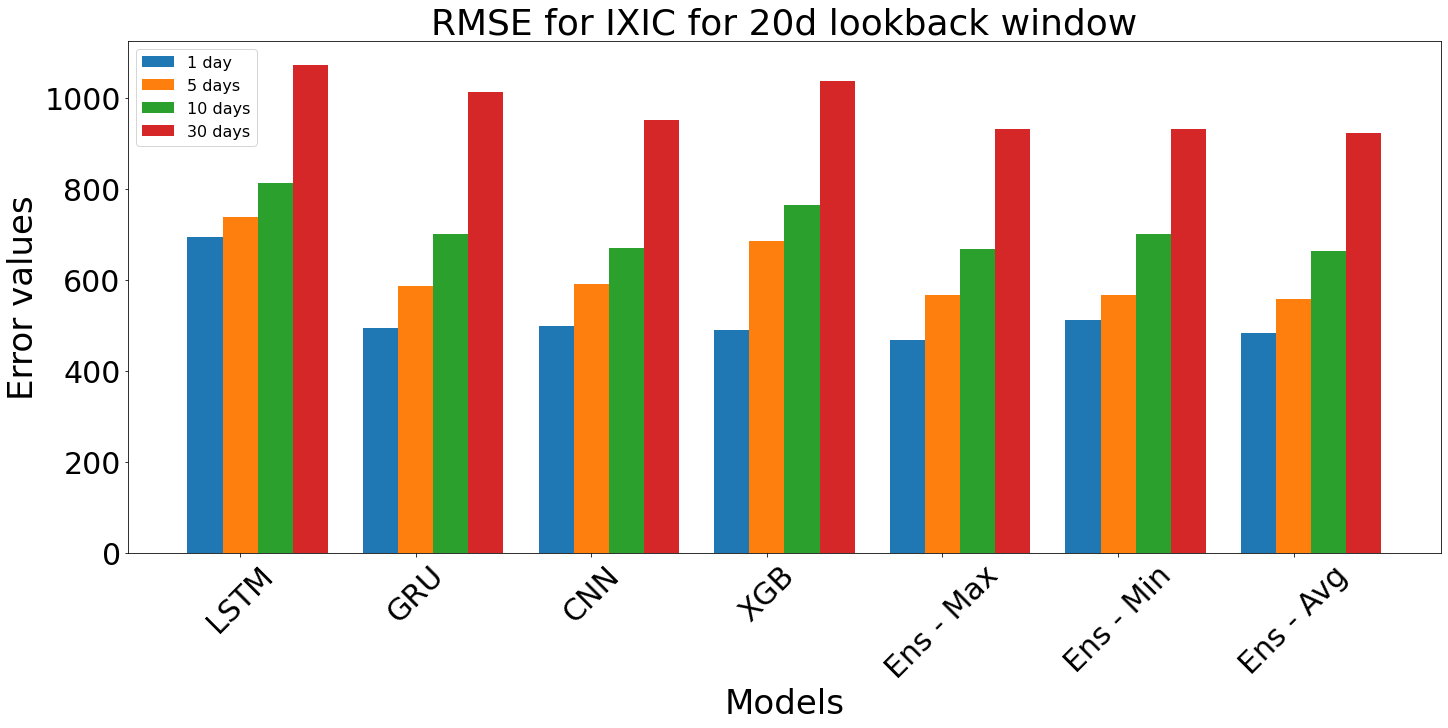

<Figure size 1440x720 with 0 Axes>

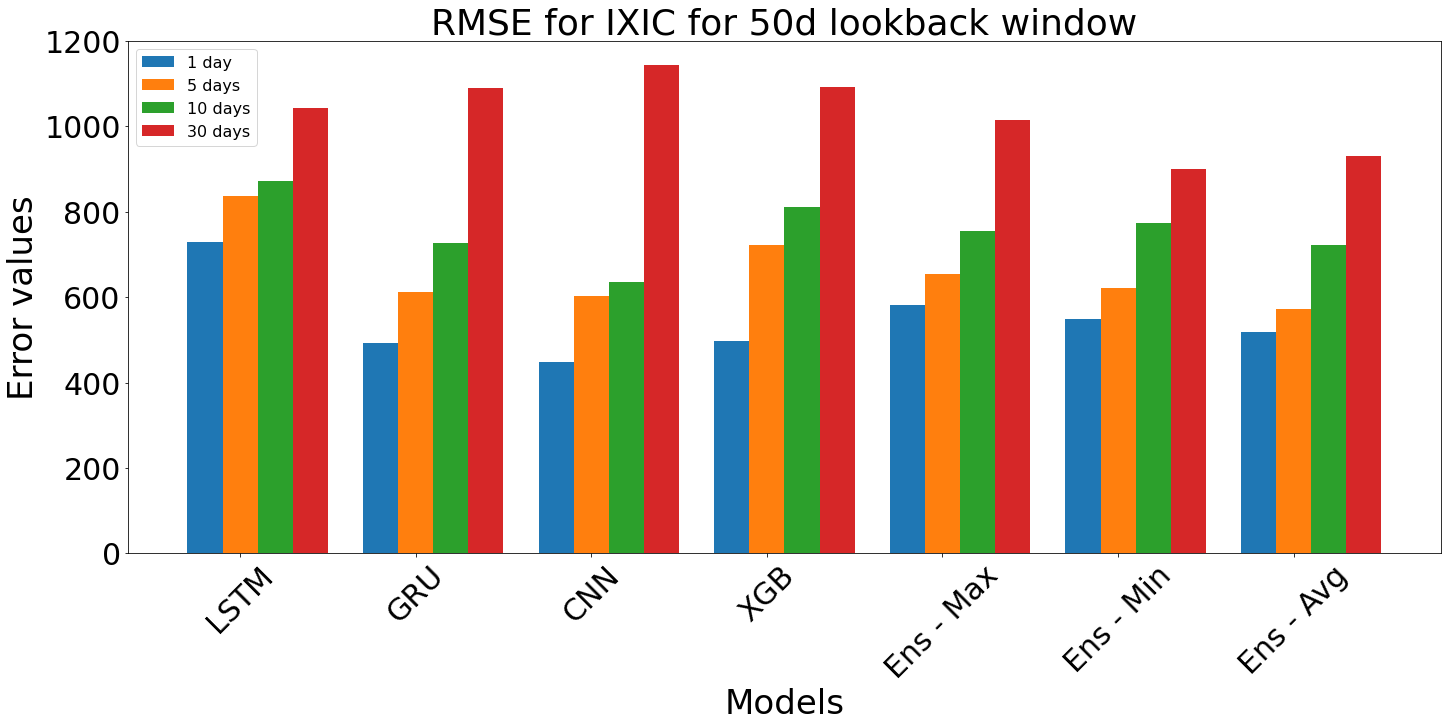

<Figure size 1440x720 with 0 Axes>

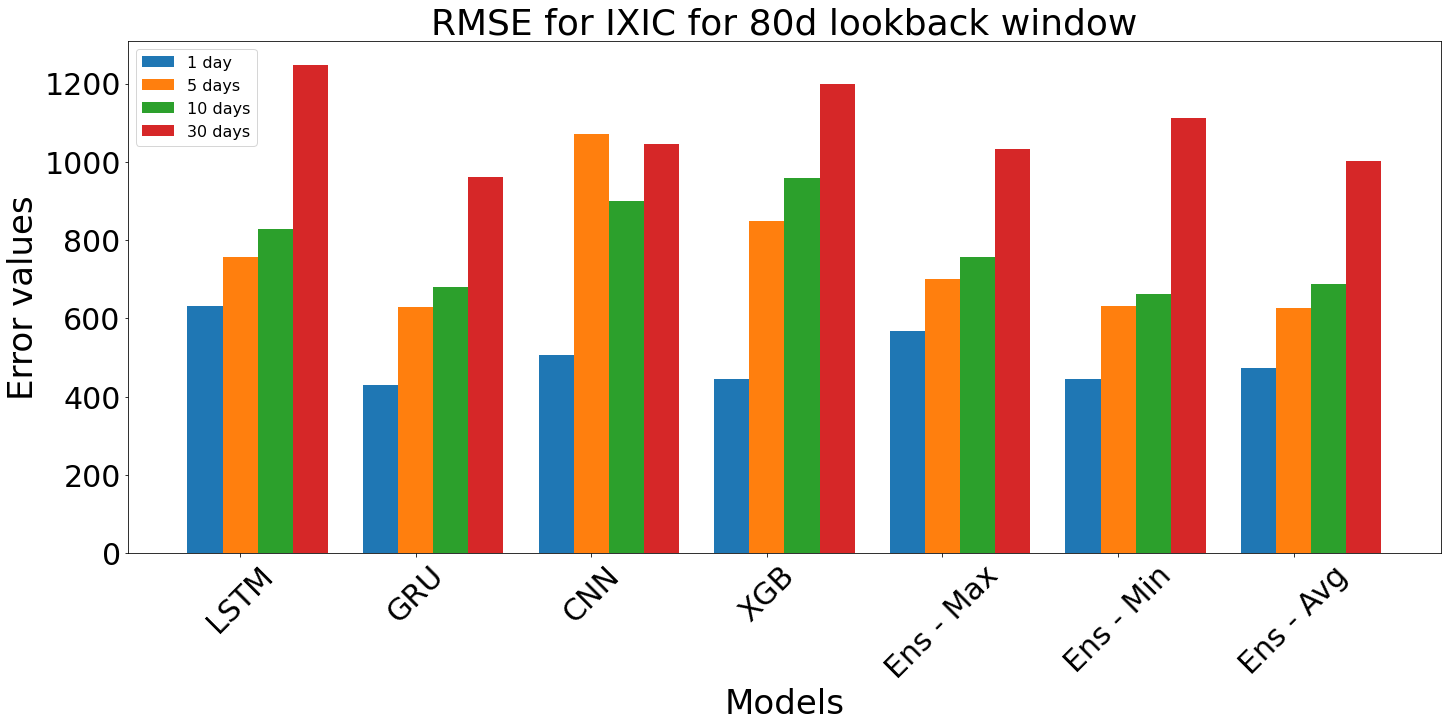

<Figure size 1440x720 with 0 Axes>

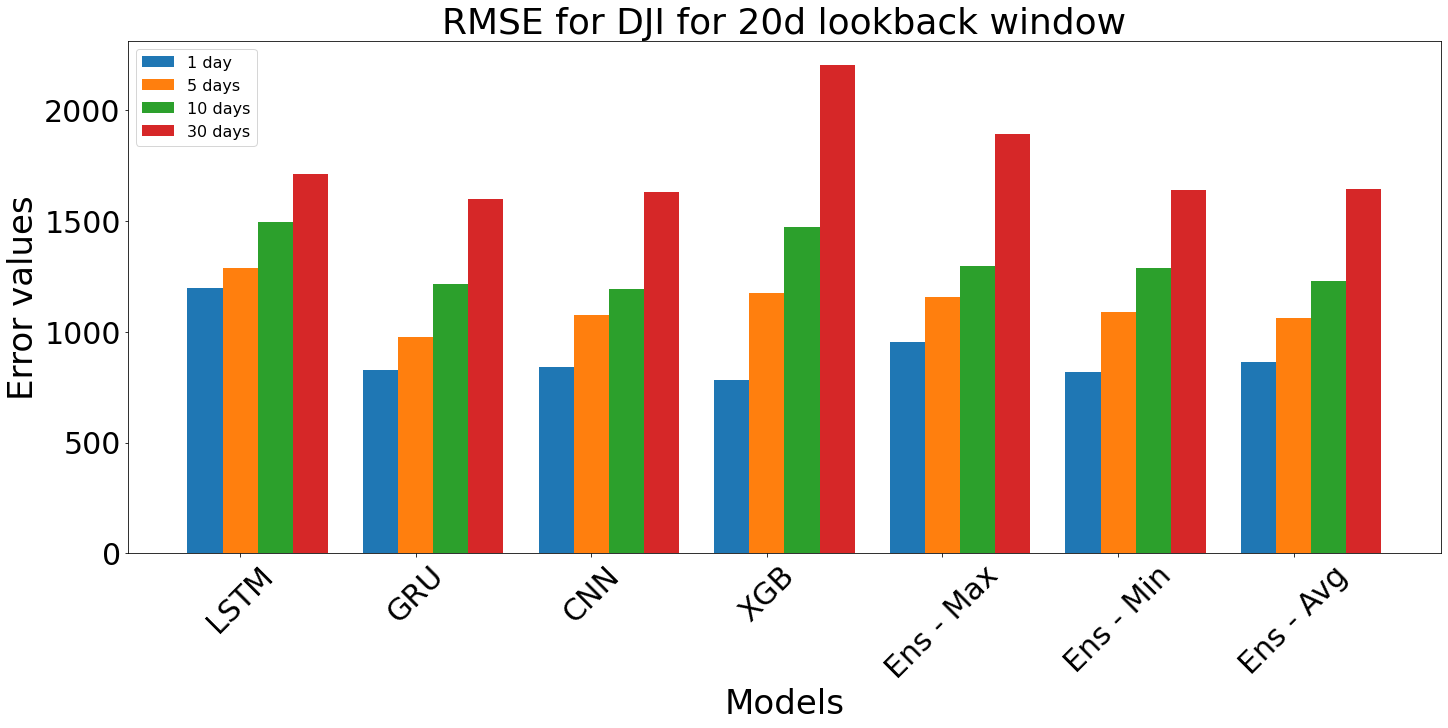

<Figure size 1440x720 with 0 Axes>

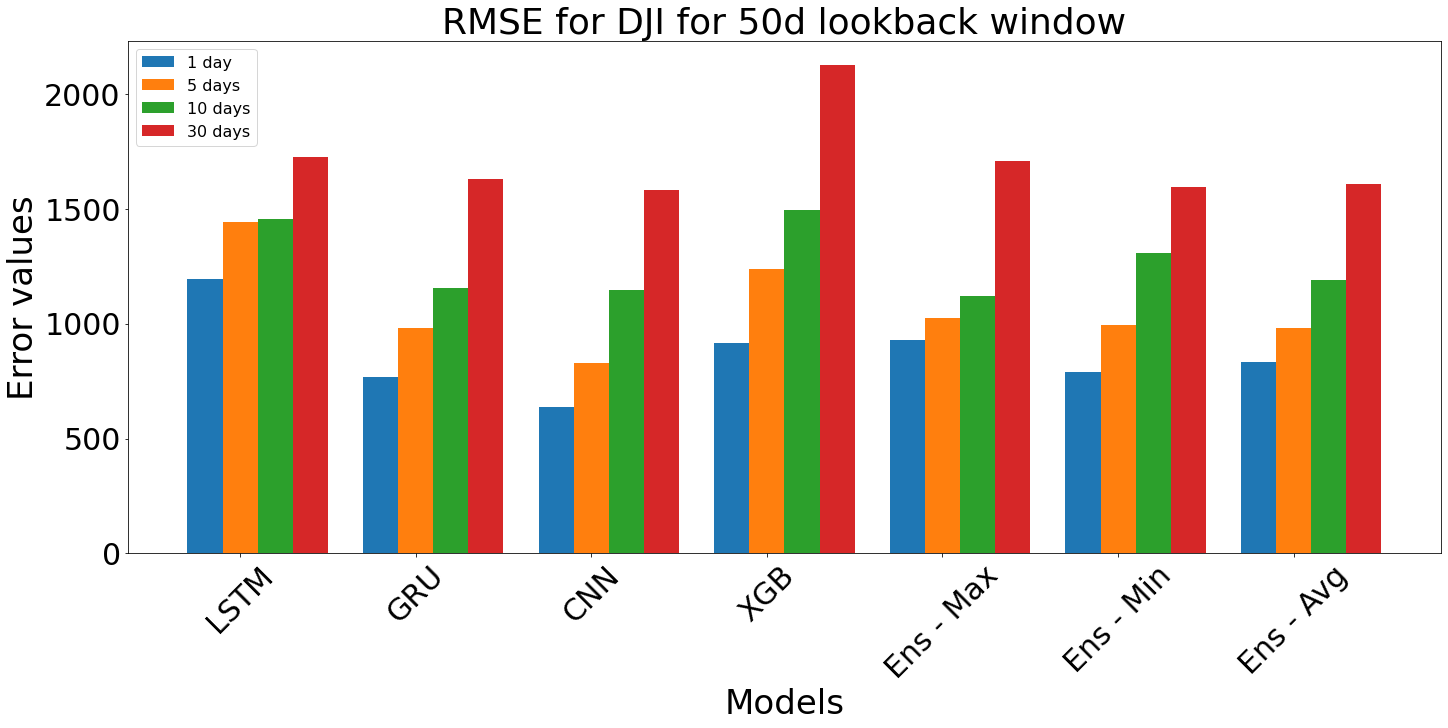

<Figure size 1440x720 with 0 Axes>

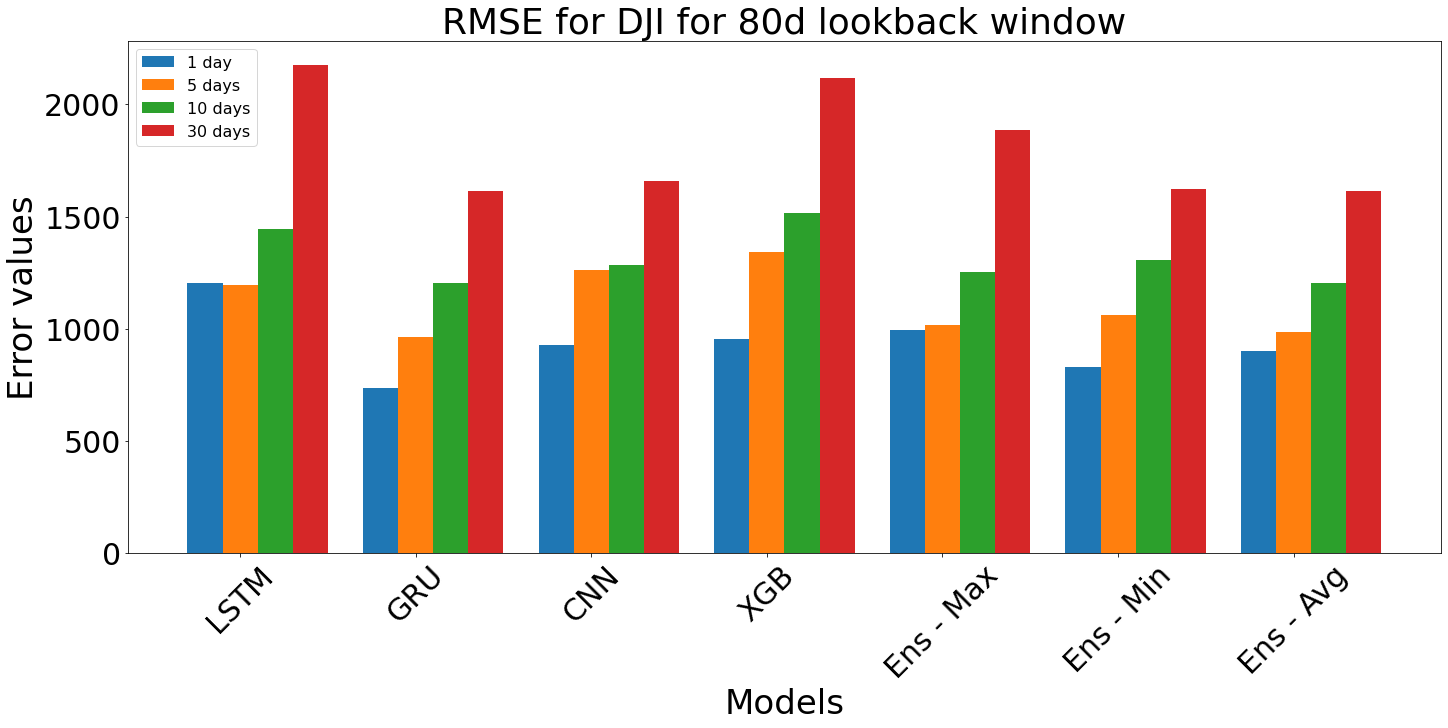

<Figure size 1440x720 with 0 Axes>

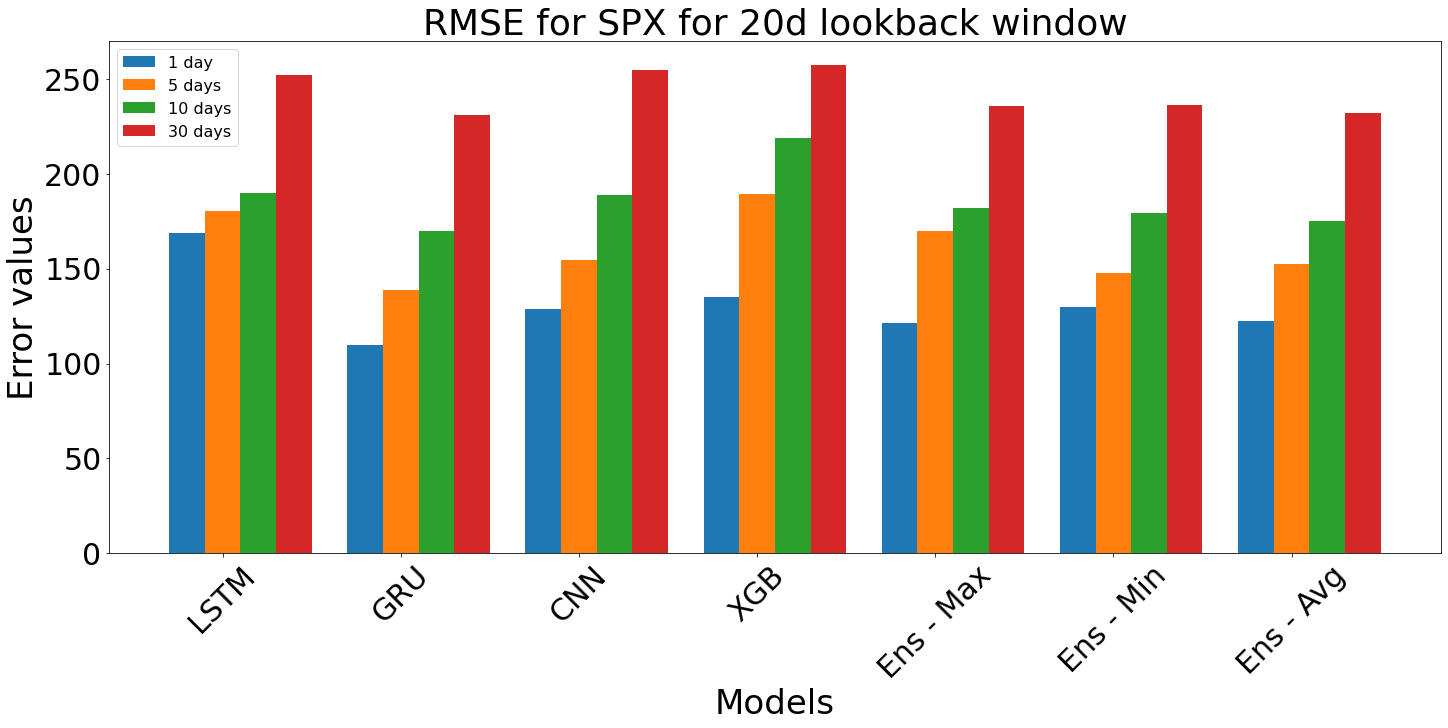

<Figure size 1440x720 with 0 Axes>

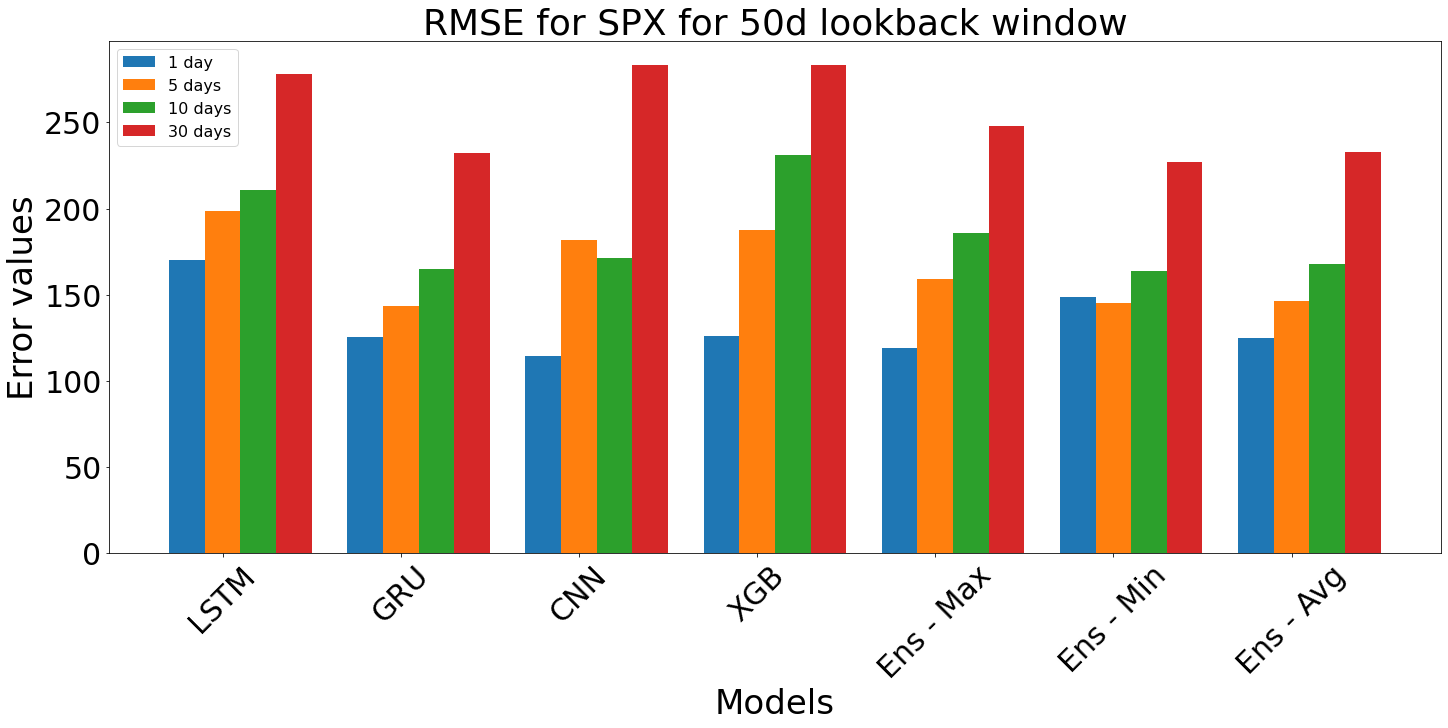

<Figure size 1440x720 with 0 Axes>

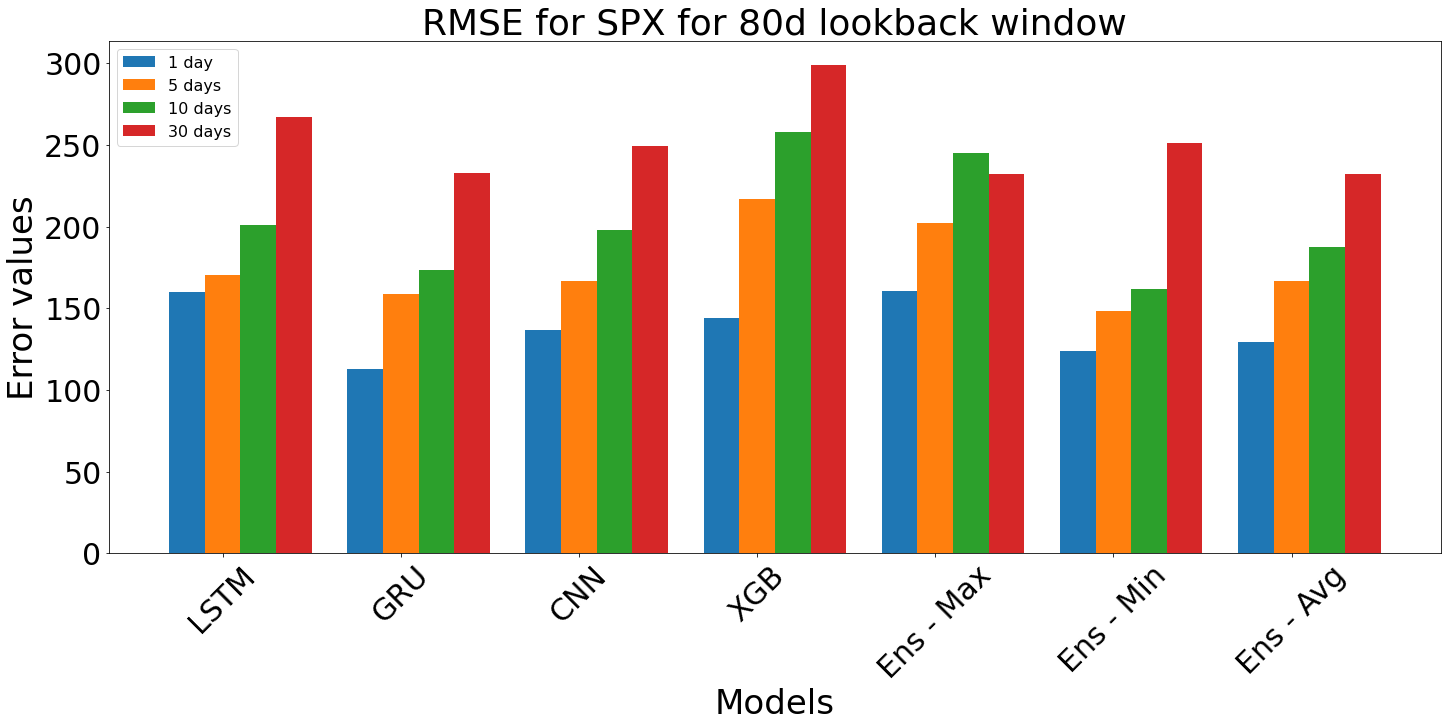

<Figure size 1440x720 with 0 Axes>

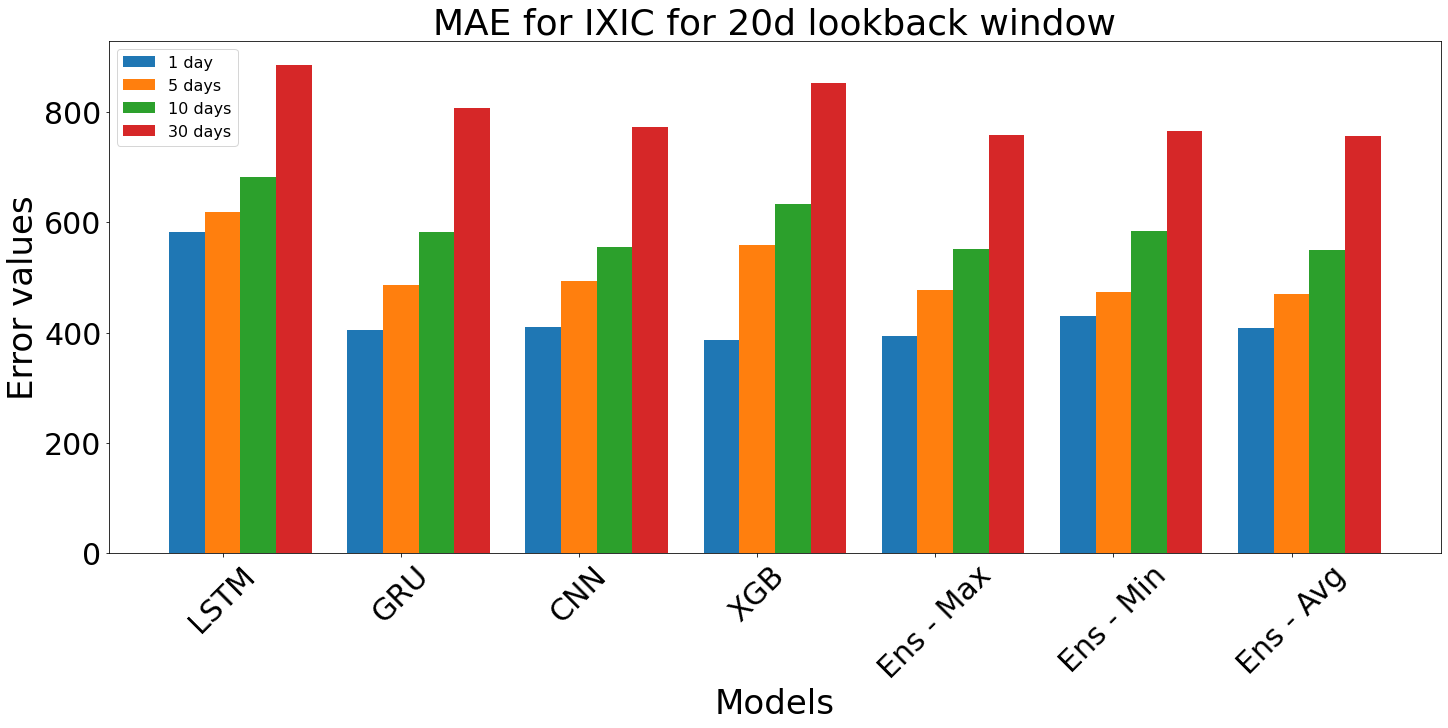

<Figure size 1440x720 with 0 Axes>

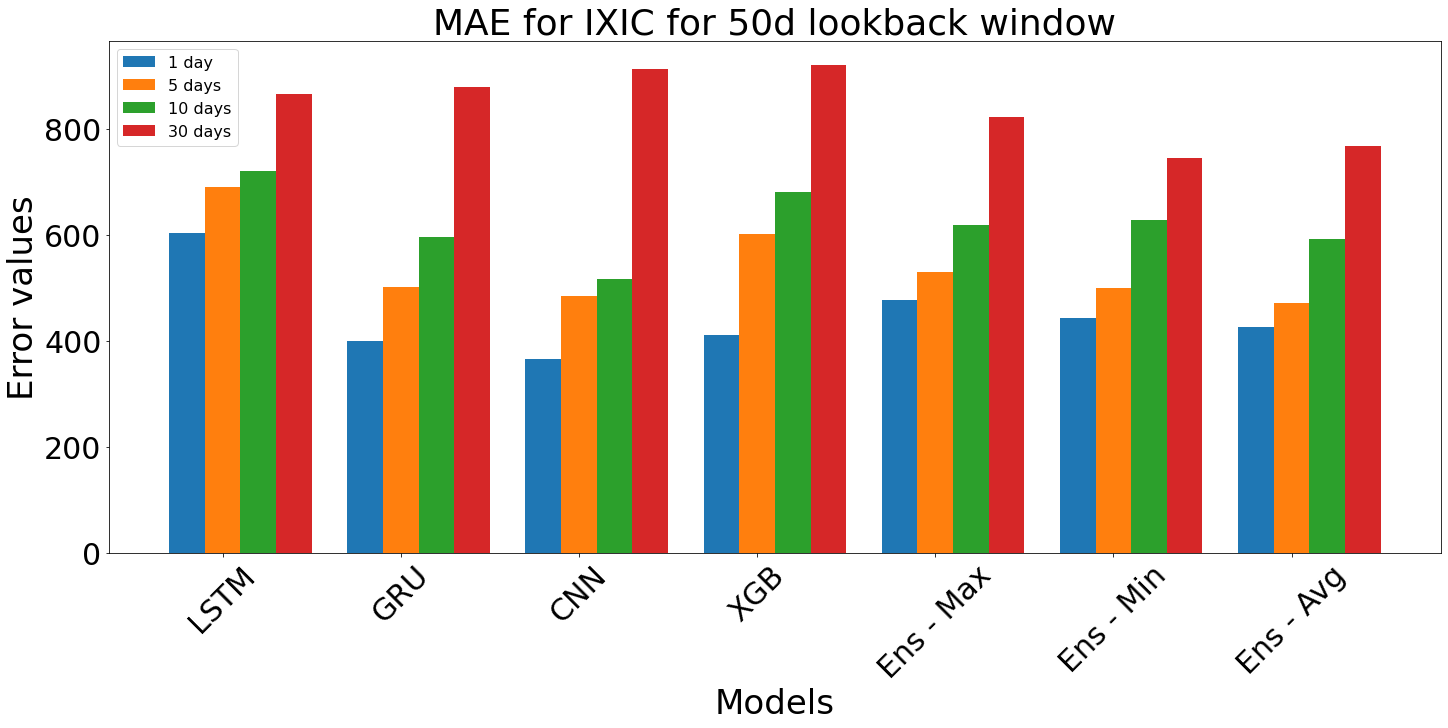

<Figure size 1440x720 with 0 Axes>

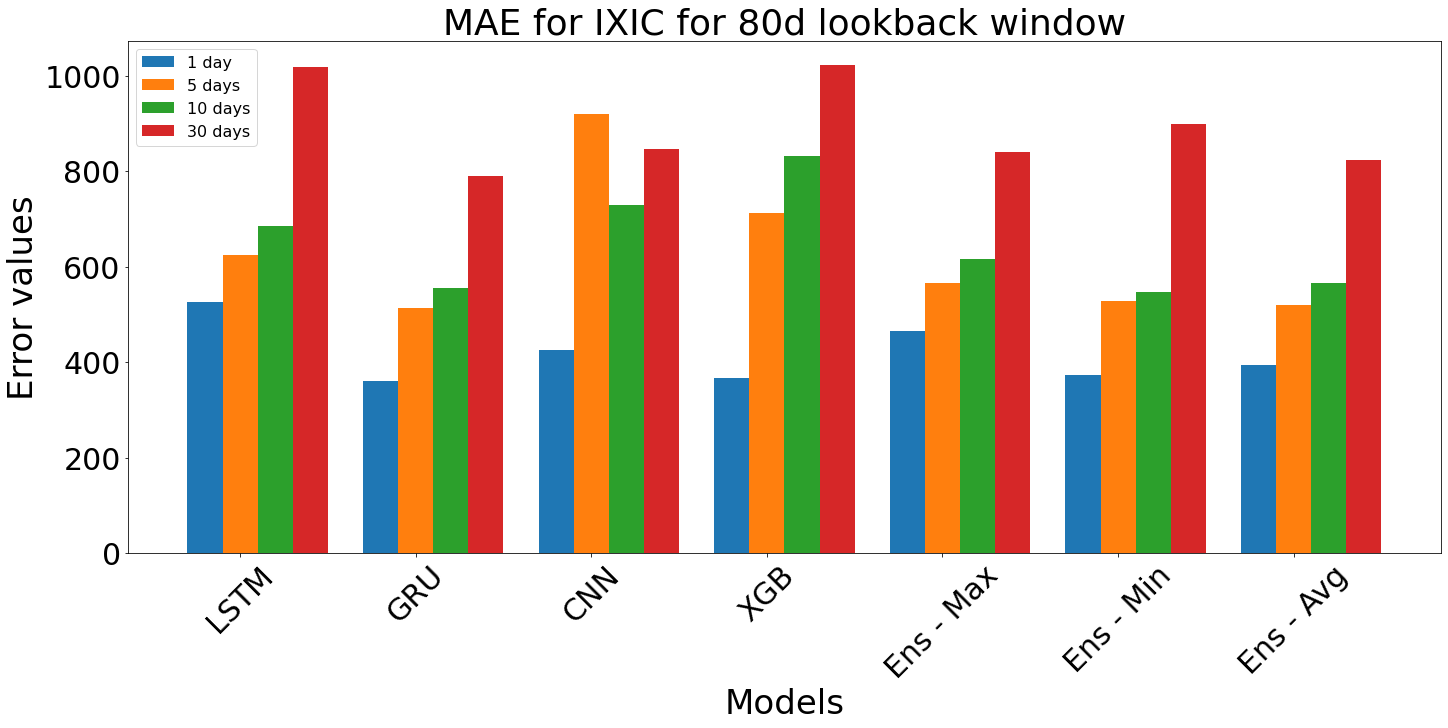

<Figure size 1440x720 with 0 Axes>

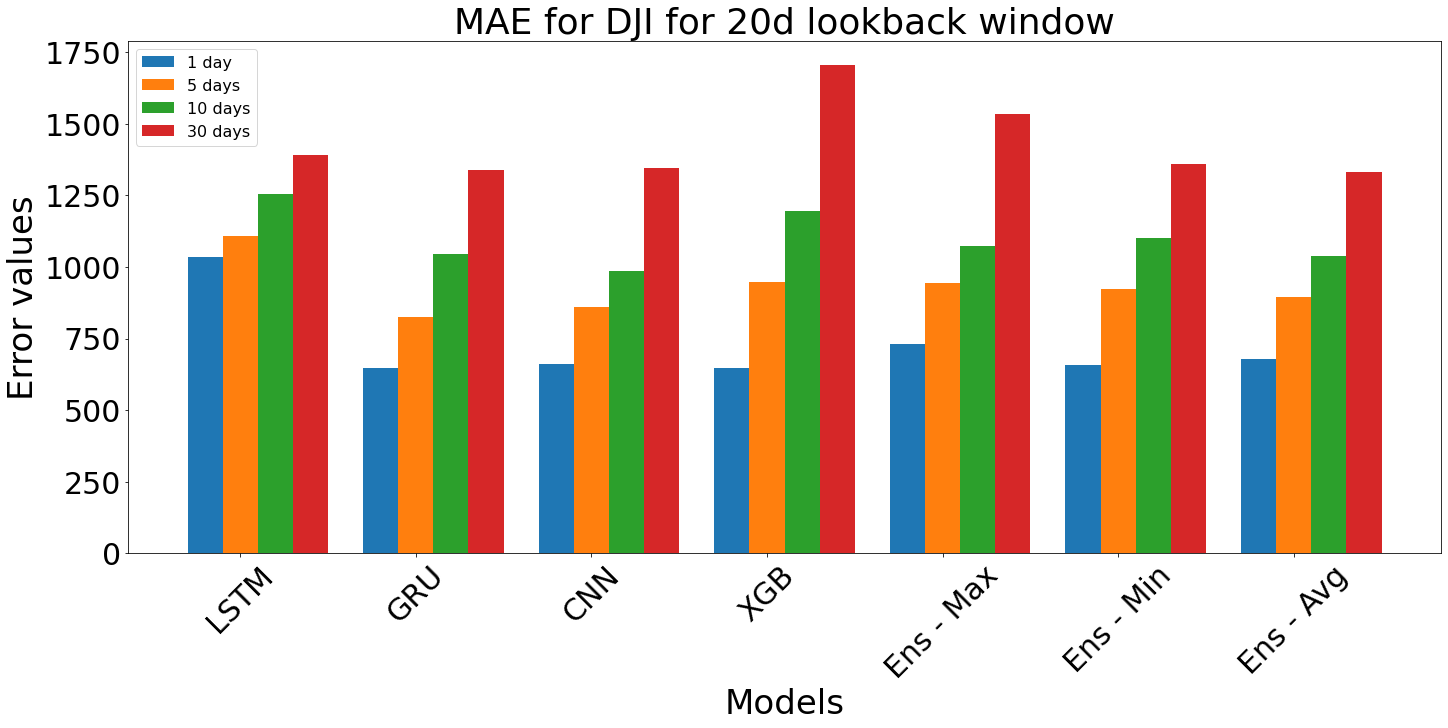

<Figure size 1440x720 with 0 Axes>

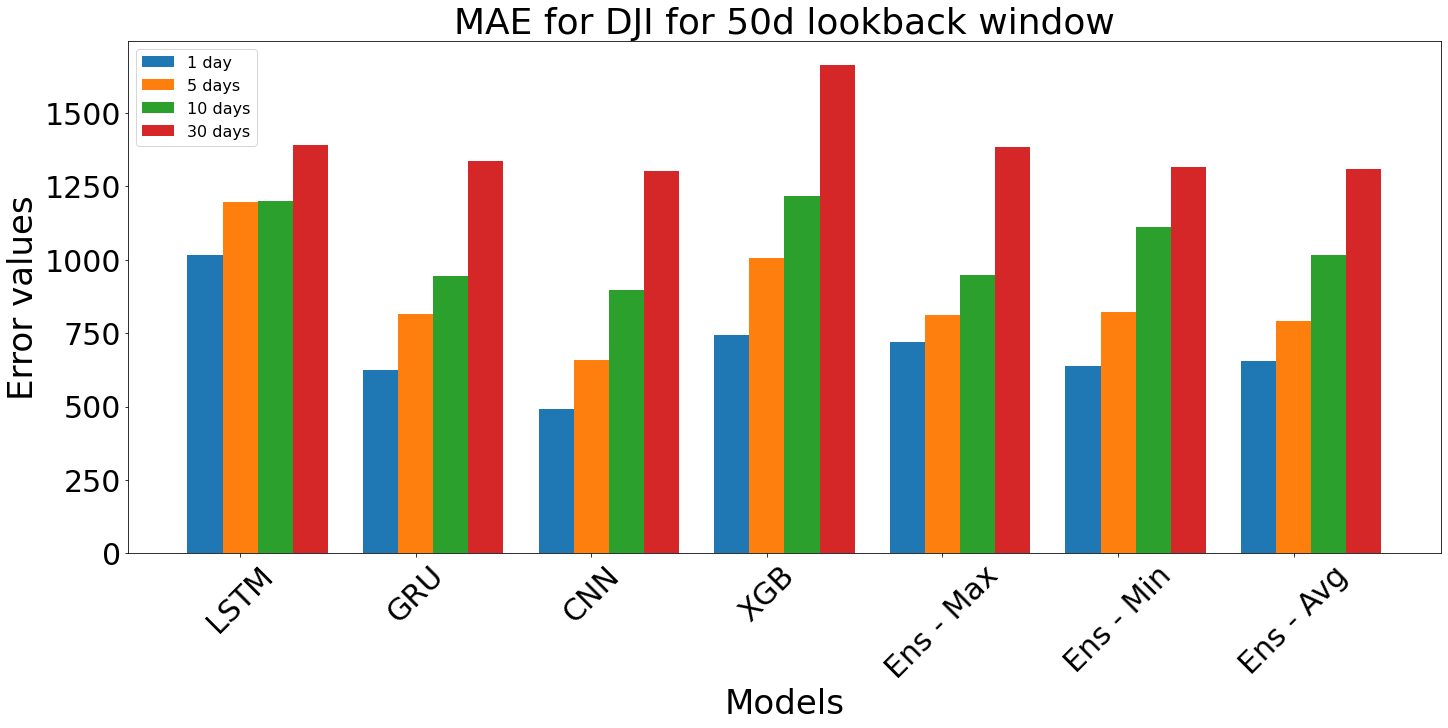

<Figure size 1440x720 with 0 Axes>

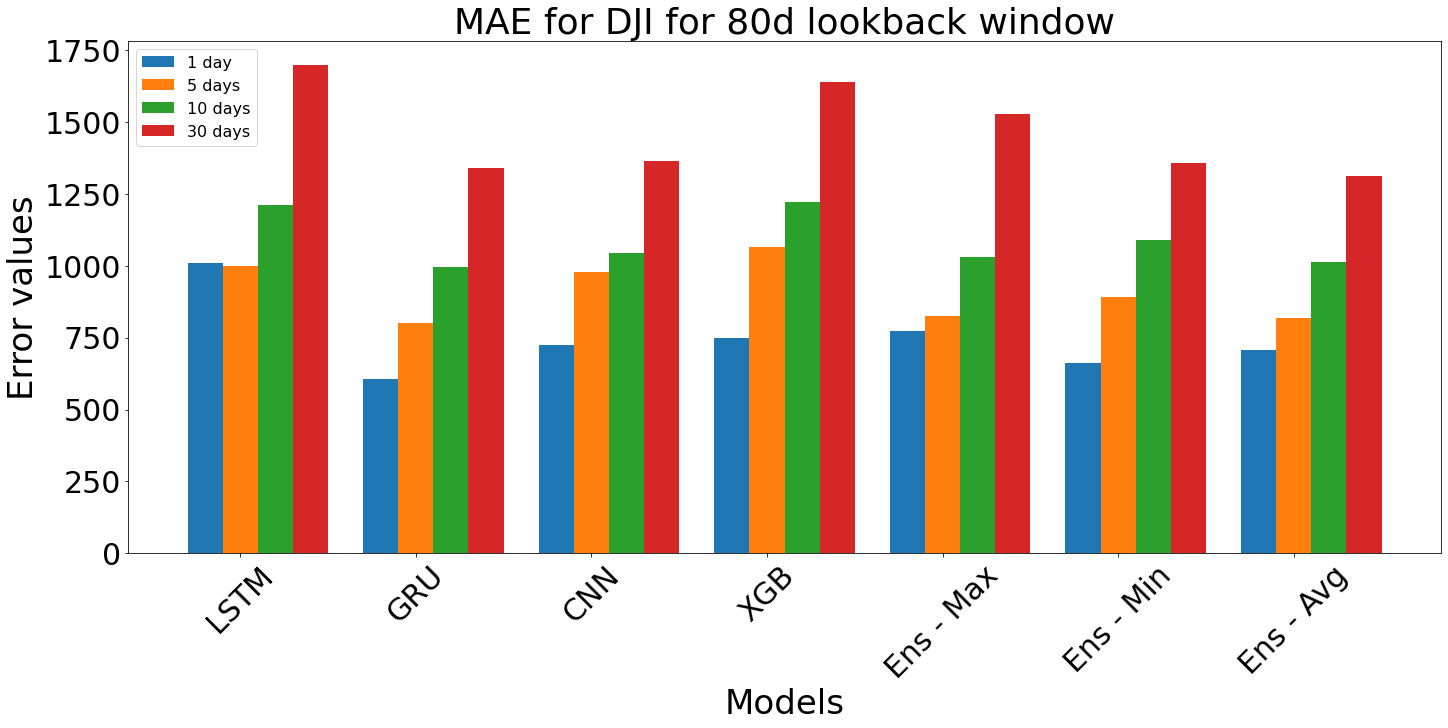

<Figure size 1440x720 with 0 Axes>

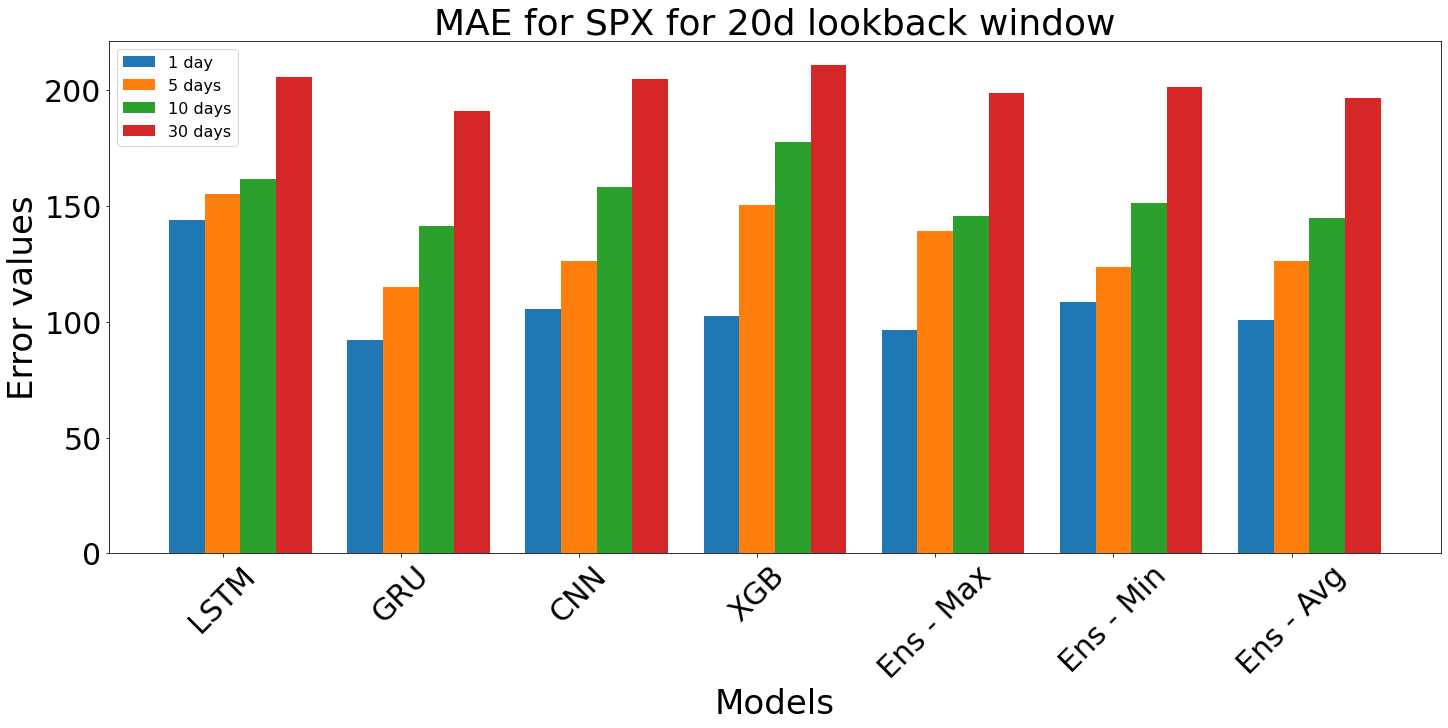

<Figure size 1440x720 with 0 Axes>

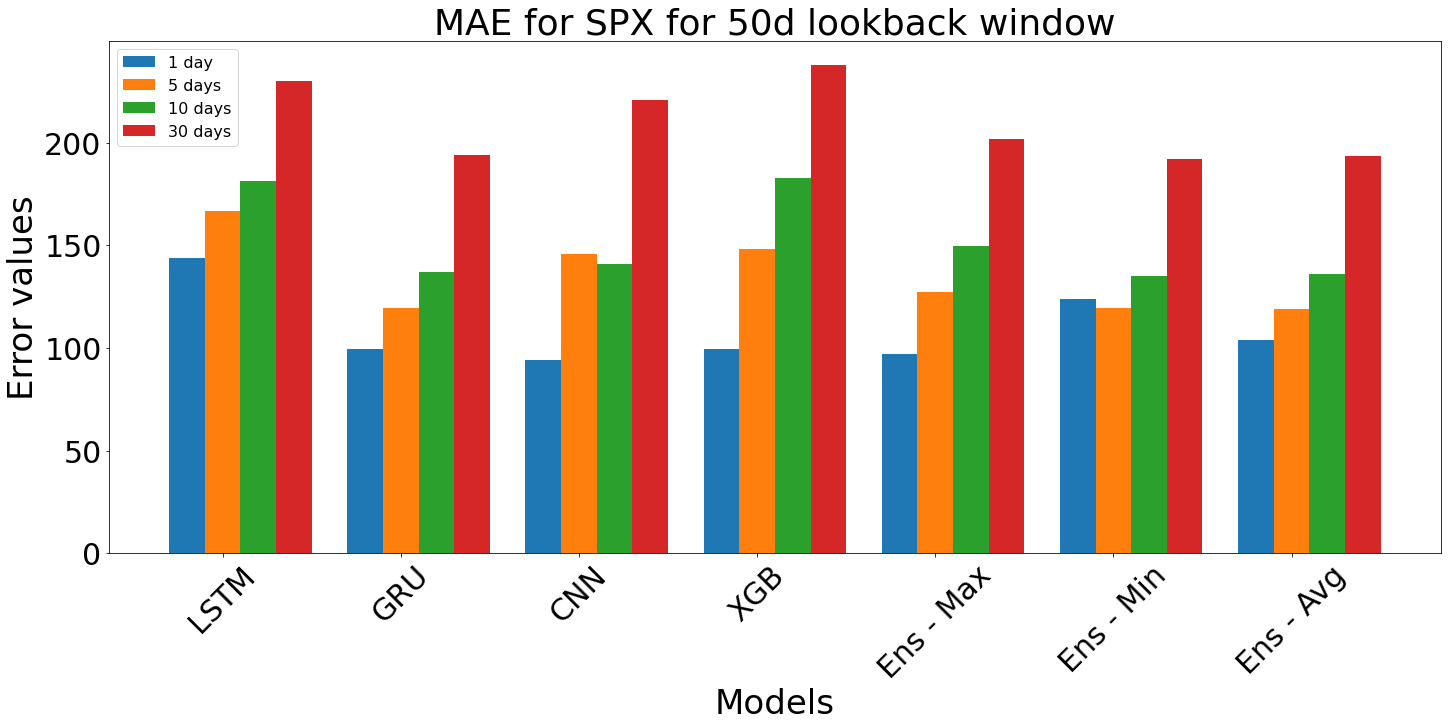

<Figure size 1440x720 with 0 Axes>

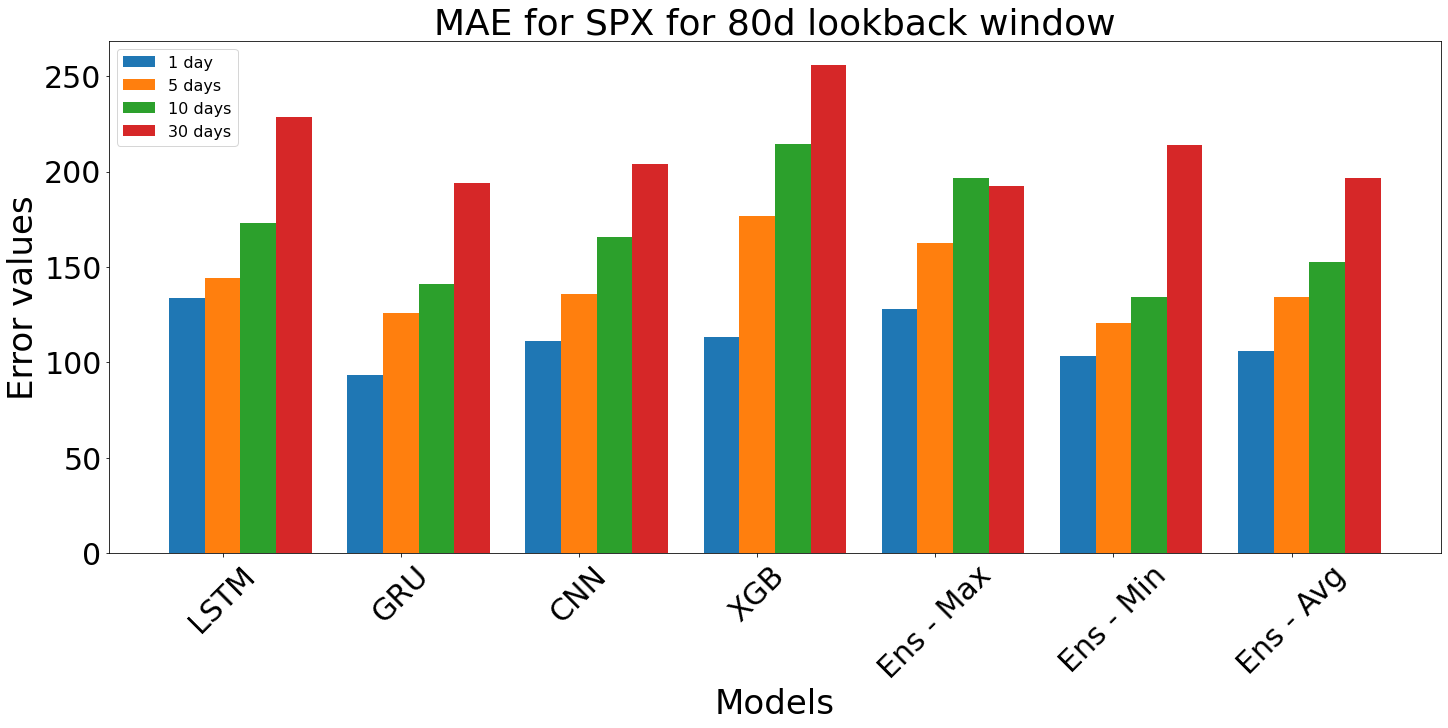

<Figure size 1440x720 with 0 Axes>

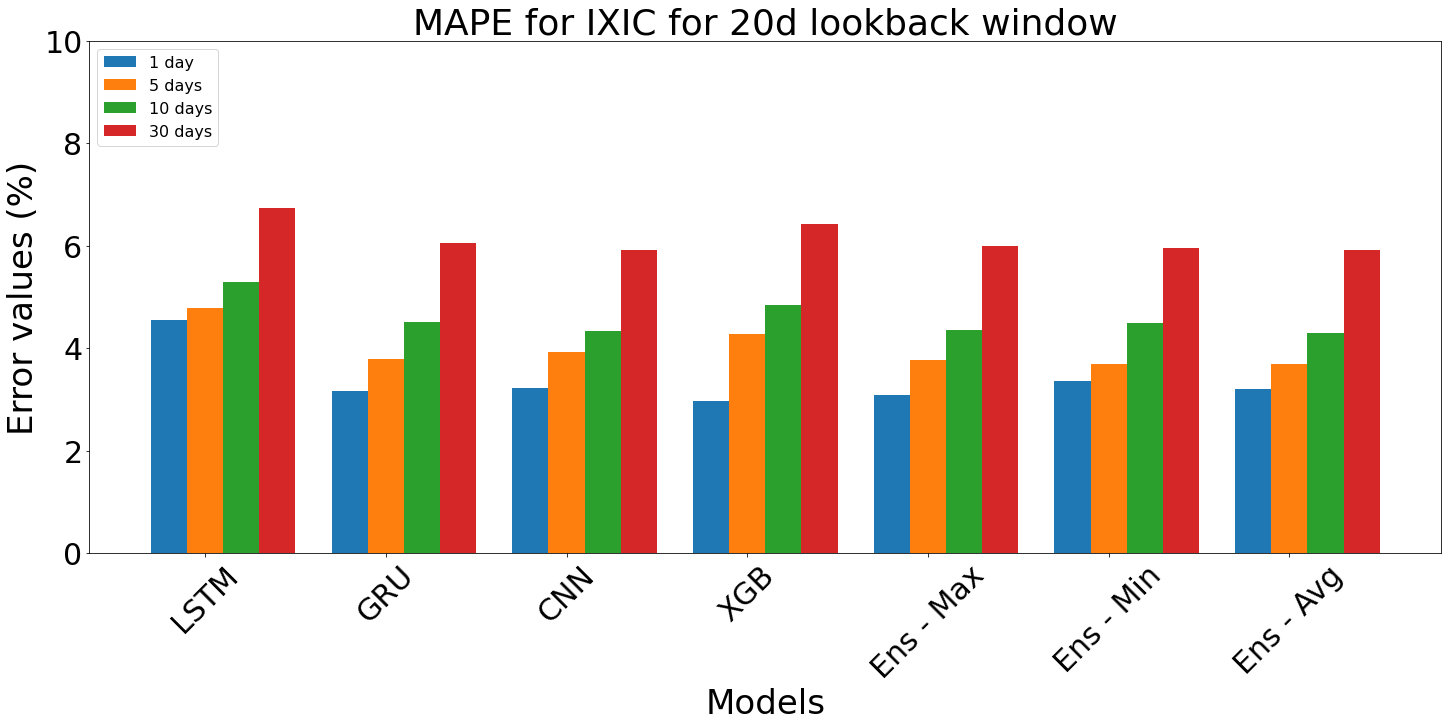

<Figure size 1440x720 with 0 Axes>

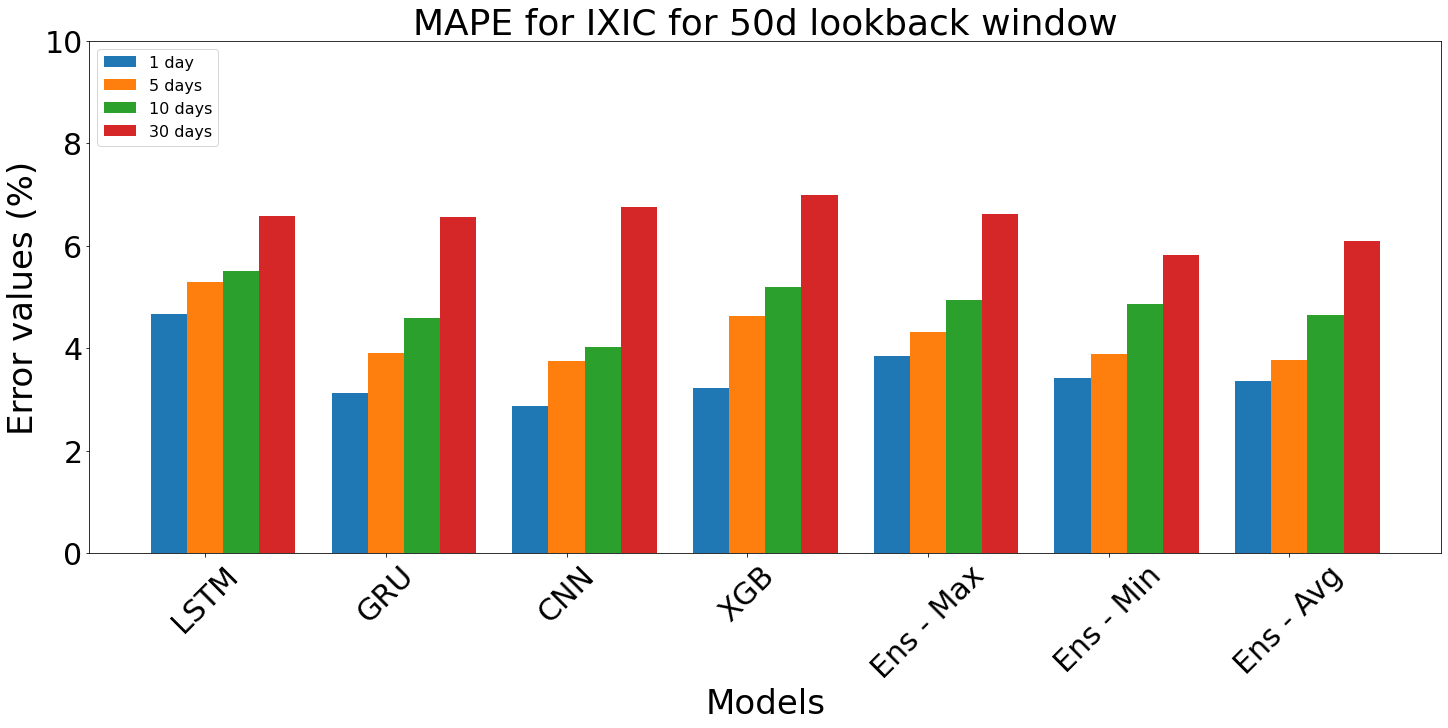

<Figure size 1440x720 with 0 Axes>

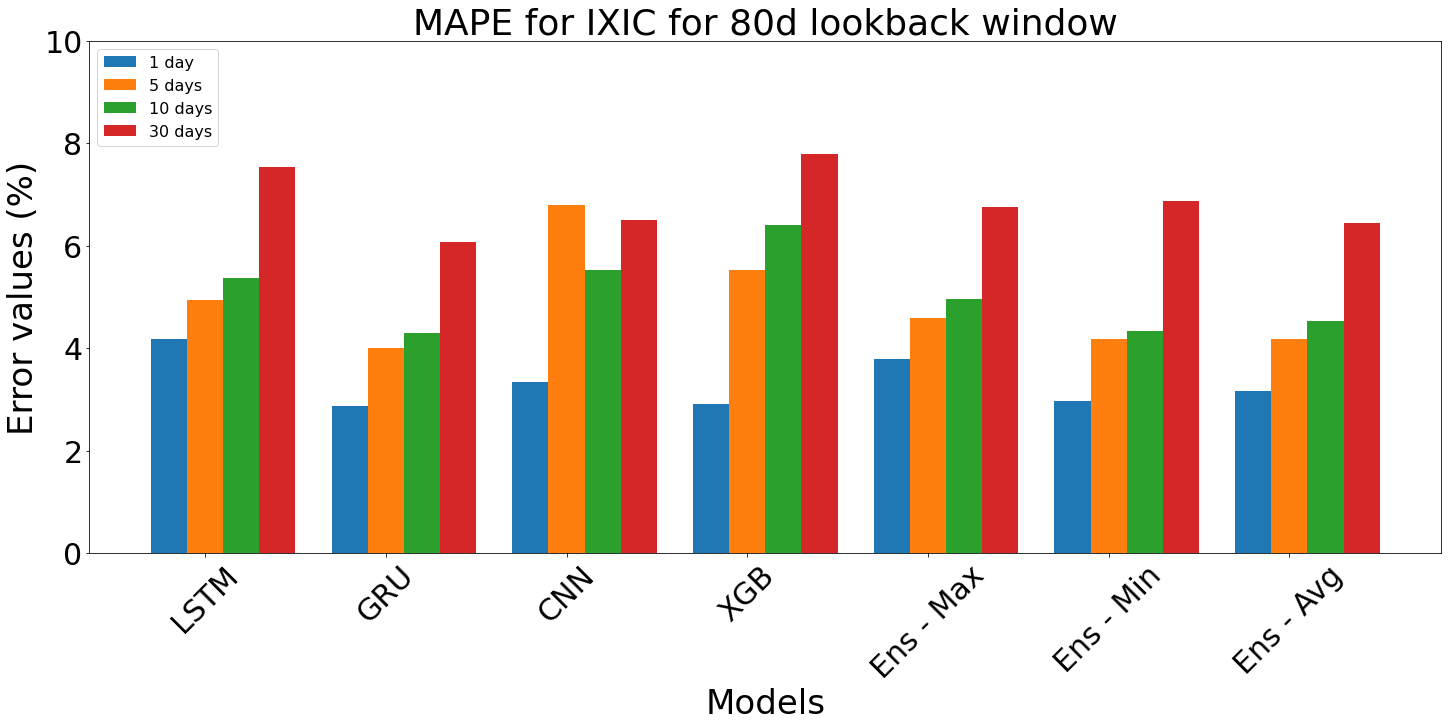

<Figure size 1440x720 with 0 Axes>

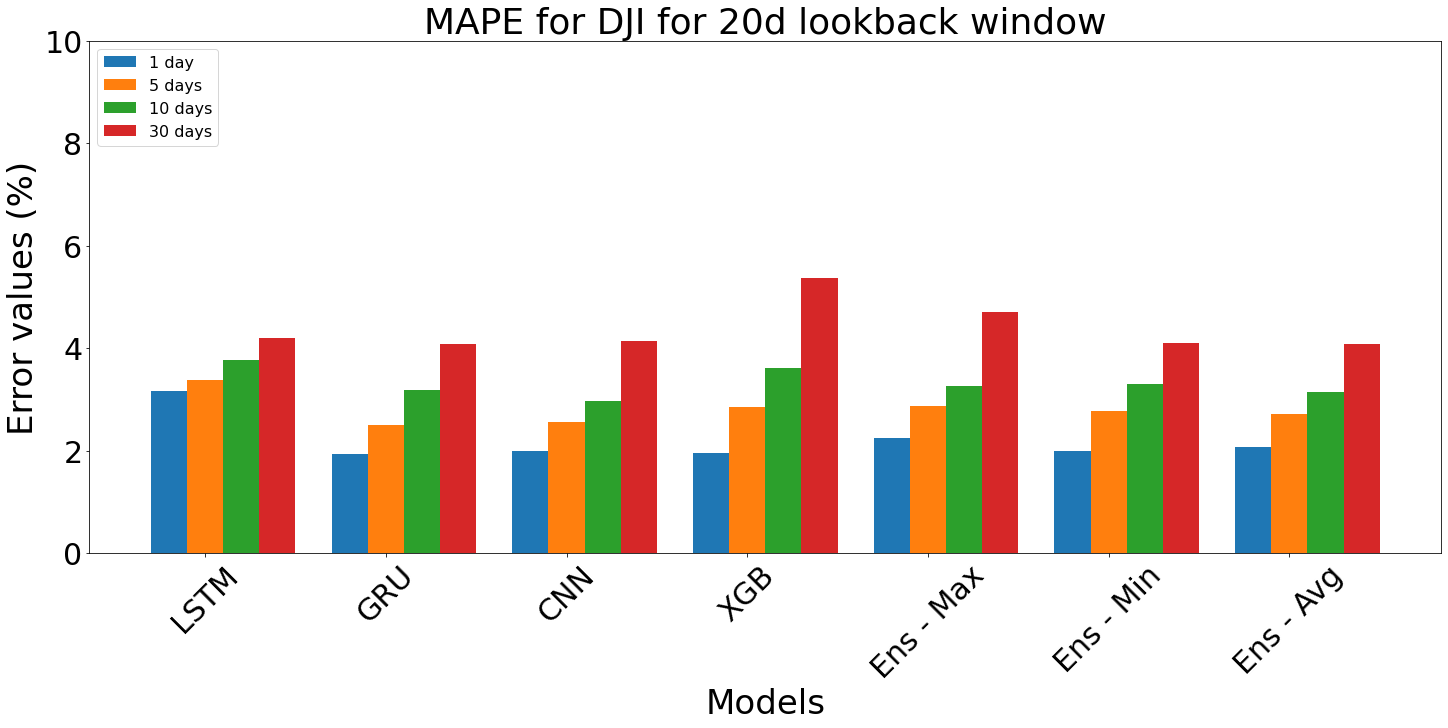

<Figure size 1440x720 with 0 Axes>

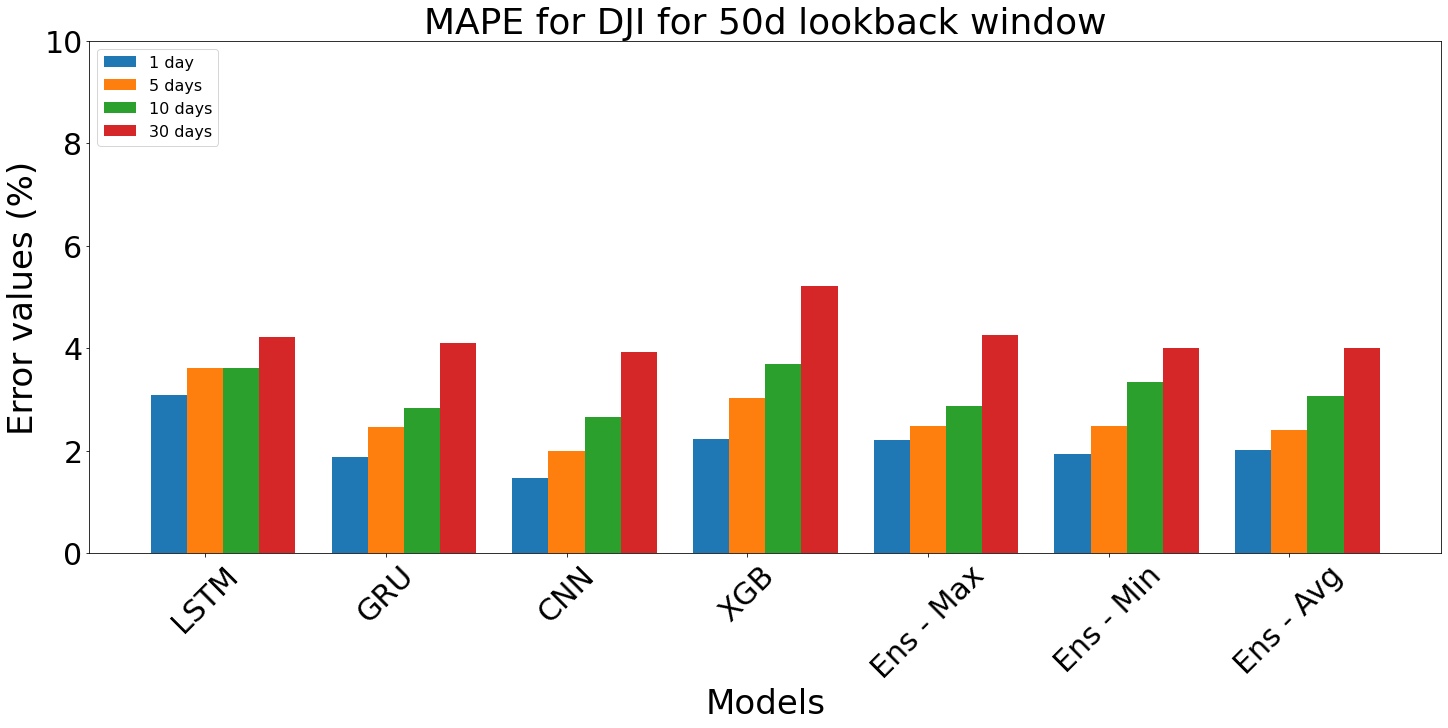

<Figure size 1440x720 with 0 Axes>

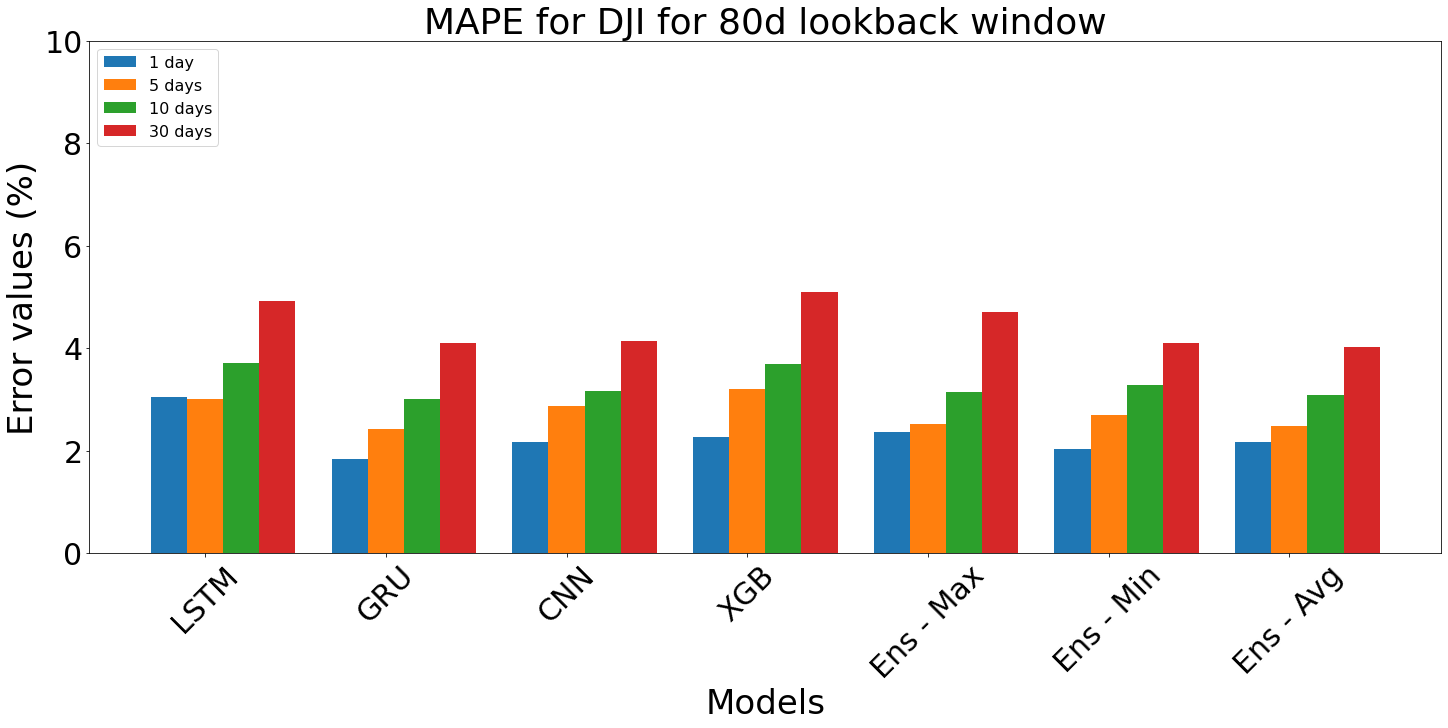

<Figure size 1440x720 with 0 Axes>

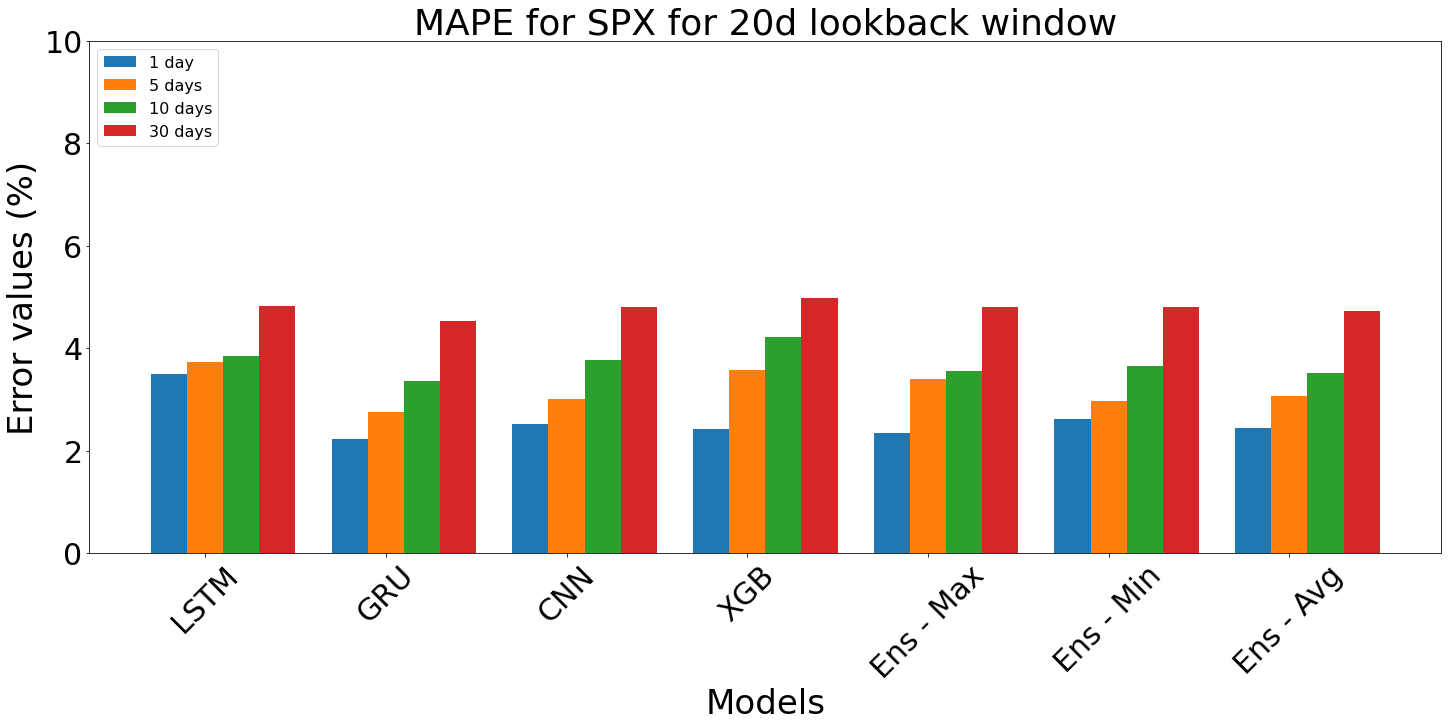

<Figure size 1440x720 with 0 Axes>

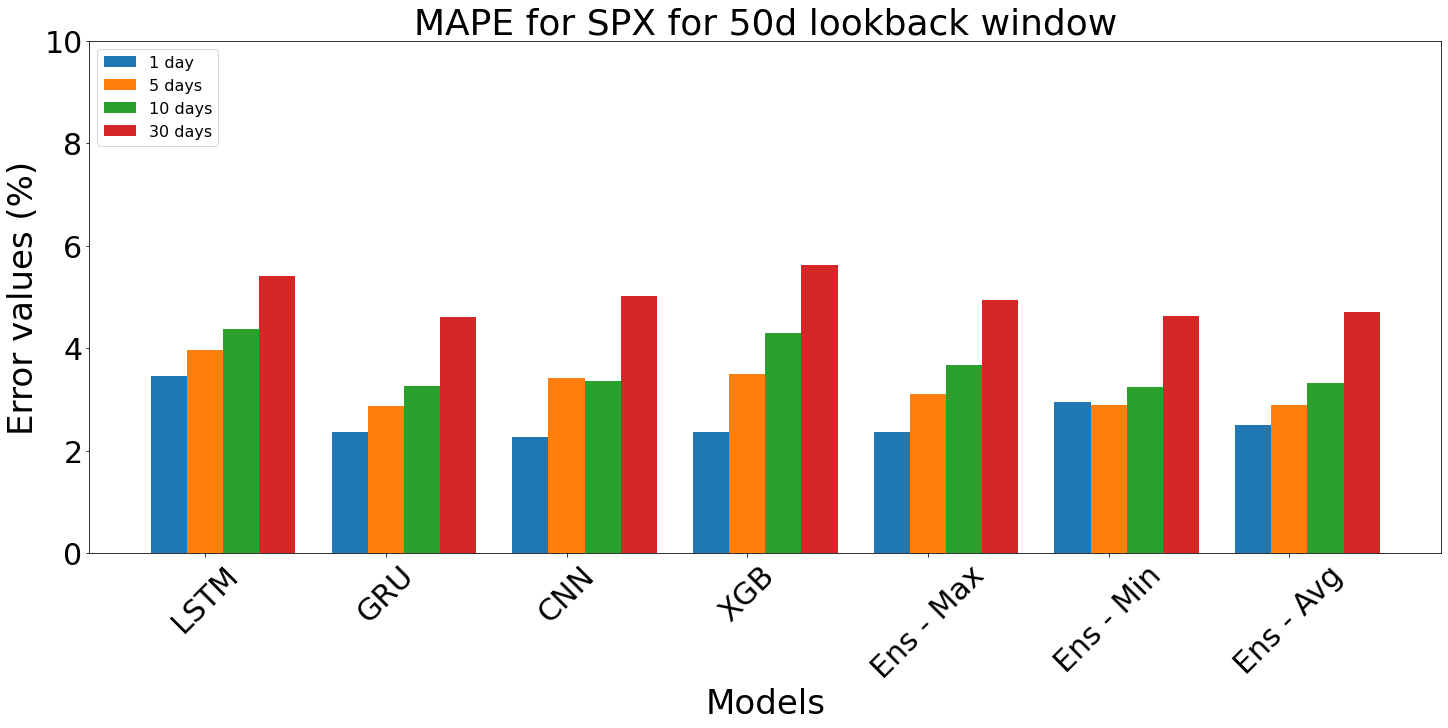

<Figure size 1440x720 with 0 Axes>

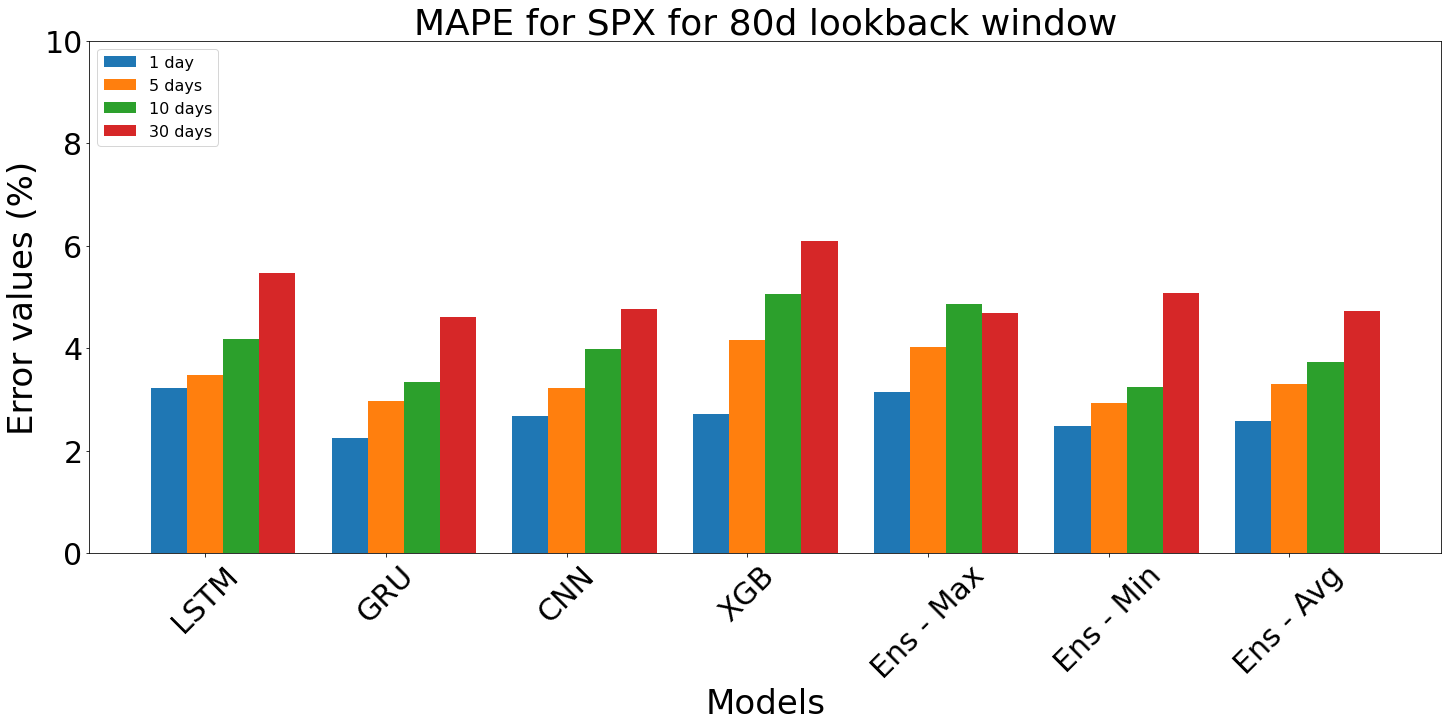

<Figure size 1440x720 with 0 Axes>

In [271]:
species = ("Adelie", "Chinstrap", "Gentoo")
# models = ('GRU_20d', 'GRU_50d', 'GRU_80d',
#           'LSTM_20d', 'LSTM_50d', 'LSTM_80d',
#           'CNN_20d', 'CNN_50d', 'CNN_80d', 
#           'XGB_20d', 'XGB_50d', 'XGB_80d',
#           'Ensemble - Min_20d','Ensemble - Min_50d', 'Ensemble - Min_80d'
#           'Ensemble - Max_20d','Ensemble - Max_50d', 'Ensemble - Max_80d' 
#           'Ensemble - Avg_20d','Ensemble - Avg_50d', 'Ensemble - Avg_80d')
models = ('LSTM',
          'GRU',
          'CNN',
          'XGB',
          'Ens - Max',
          'Ens - Min',
          'Ens - Avg')

# ERR = 'MAPE'
# DATASET = 'IXIC'
# WINDOW = '20d'   
plt.rc('axes', labelsize=12)

for ERR in ['RMSE', 'MAE', 'MAPE']:
    for DATASET in ['IXIC', 'DJI', 'SPX']:
        for WINDOW in ['20d', '50d', '80d']:
            model_errors = {
                '1 day':  tuple(bar_viz.loc['1_day', f"{ERR}", f"{DATASET}", f"{WINDOW}"]),
                '5 days': tuple(bar_viz.loc['5_days', f"{ERR}", f"{DATASET}", f"{WINDOW}"]),
                '10 days': tuple(bar_viz.loc['10_days', f"{ERR}", f"{DATASET}", f"{WINDOW}"]),
                '30 days': tuple(bar_viz.loc['1_month', f"{ERR}", f"{DATASET}", f"{WINDOW}"])
            }


            # model_errors = {
            #     '1 day': (gru.loc[f"{DATASET}", f"{ERR}"]['1_day'], ),
            #     '5 days': (gru.loc[f"{DATASET}", f"{ERR}"]['5_days'], ),
            #     '10 days': (gru.loc[f"{DATASET}", f"{ERR}"]['10_days'], ),
            #     '30 days': (gru.loc[f"{DATASET}", f"{ERR}"]['30_days'], )
            # }

            x = np.arange(len(models))  # the label locations
            width = 0.2  # the width of the bars
            multiplier = 0

            fig, ax = plt.subplots(layout='constrained')
            plt.rcParams['font.size'] = '30'
            plt.xticks(rotation = 45)
            for attribute, measurement in model_errors.items():
                offset = width * multiplier
                rects = ax.bar(x + offset, measurement, width, label=attribute)
                # ax.bar_label(rects, padding=3)
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            if ERR in 'MAPE':
                ax.set_ylabel('Error values (%)', fontsize=34)
            else:
                ax.set_ylabel('Error values', fontsize=34)
            ax.set_xlabel('Models', fontsize=34)
            ax.set_title(f"{ERR} for {DATASET} for {WINDOW} lookback window")
            ax.set_xticks(x + width, models)
            
            ax.legend(loc='upper left', fontsize=16)
            if ERR in 'MAPE':
                ax.set_ylim(0, 10)
            # else:
            #     ax.set_ylim(0, 2000)

            plt.show()

            fig.savefig(
                        f"../img/{ERR} for {DATASET} for {WINDOW} lookback window.jpg", 
                        bbox_inches='tight', dpi=120
                        )

            plt.clf()

In [2]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mean_squared_error(x,y)) ,4))

In [2]:
def run_simulation(tickerSymbol, returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.items(), total=len(returns)): #.iloc[14:]
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print(f'Sold at ${sell_price}')
                print(f'Predicted Return: {round(pred,4)}')
                print(f'Actual Return: {round(ret, 4)}')
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                # #fit model
                # model = ARIMA(curr_data, order=order).fit(maxiter=200)

                # #get forecast
                # pred = model.forecast()[0][0]
                pipe = pipeline.Pipeline([
                    ("fourier", ppc.FourierFeaturizer(m=4)),
                    ("arima", arima.AutoARIMA(stepwise=True, 
                    trace=1, 
                    error_action="ignore",
                    seasonal=False,  # because we use Fourier
                    suppress_warnings=True))
                ])

                pipe.fit(xtrain)
                pred, _ = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
                
            except:
                pred = thresh - 1
                
                


        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        # plt.figure(figsize=(10,4))
        # plt.plot(prices[14:])
        prices.plot() # [14:]

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [3]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024


# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [4]:
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')

In [5]:
spy_ohlc_df.isnull().values.any(), dow_jones_ohlc_df.isnull().values.any(), 

(False, False)

In [19]:
dow_jones_ohlc_df[-1000:]

,Date,Open,High,Low,Close,Adj Close,Volume
5668,2017-07-07,21414.300781,21414.300781,21414.300781,21414.300781,21414.300781,209593779
5669,2017-07-10,21408.500000,21408.500000,21408.500000,21408.500000,21408.500000,222552907
5670,2017-07-11,21409.099609,21409.099609,21409.099609,21409.099609,21409.099609,209657816
5671,2017-07-12,21532.099609,21532.099609,21532.099609,21532.099609,21532.099609,223314326
5672,2017-07-13,21553.099609,21553.099609,21553.099609,21553.099609,21553.099609,196064753
...,...,...,...,...,...,...,...
6663,2022-02-24,33223.800781,33223.800781,33223.800781,33223.800781,33223.800781,0
6664,2022-02-25,34058.800781,34058.800781,34058.800781,34058.800781,34058.800781,0
6665,2022-02-28,33892.601562,33892.601562,33892.601562,33892.601562,33892.601562,0
6666,2022-03-01,33294.898438,33294.898438,33294.898438,33294.898438,33294.898438,0


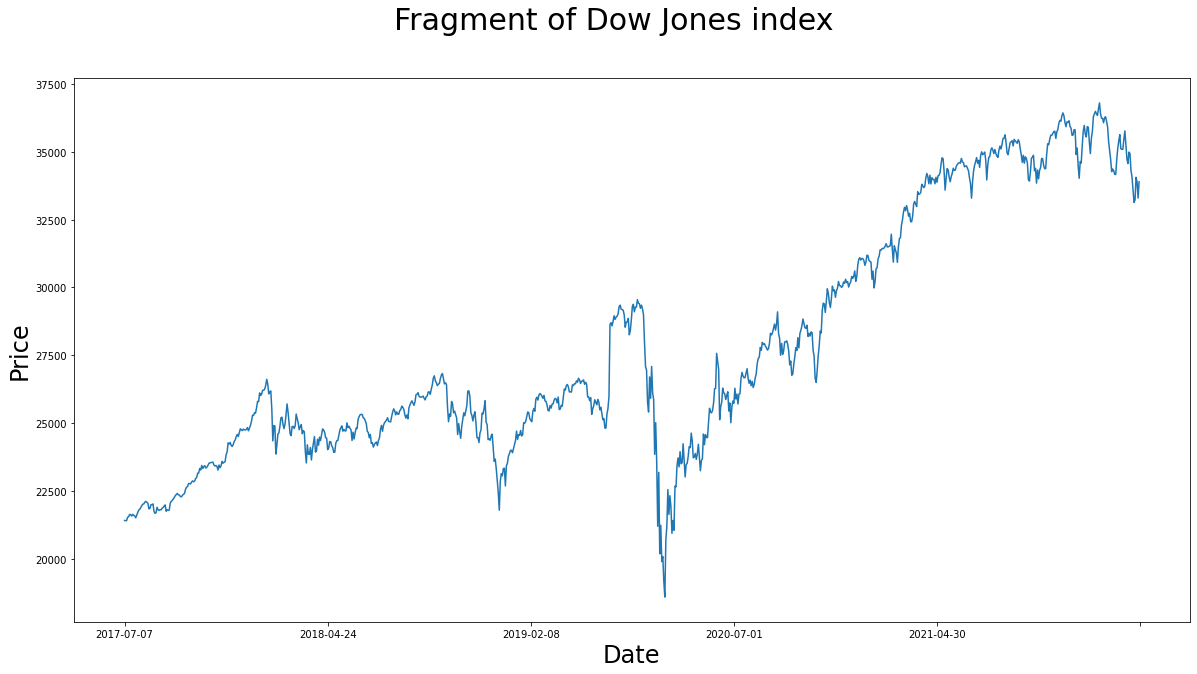

In [20]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
fig.suptitle("Fragment of Dow Jones index", fontsize=30)

ax.plot(
    'Date', 'Close', data=dow_jones_ohlc_df[-1000:]
  )
ax.set_ylabel('Price', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

In [9]:
test_stationarity(dow_jones_ohlc_df.Close[-1000:], window_size=7)

NameError: name 'test_stationarity' is not defined

In [31]:
dow_jones_returns = dow_jones_ohlc_df.Close[-1000:].pct_change().dropna()
xtrain, xvalid = model_selection.train_test_split(dow_jones_returns.values, test_size = int(len(dow_jones_returns)*0.2))

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4439.204, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4392.207, Time=1.42 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4425.165, Time=2.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4416.483, Time=1.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4440.584, Time=1.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-4443.309, Time=0.39 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-4442.263, Time=2.91 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4431.395, Time=2.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4440.163, Time=3.48 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4443.108, Time=1.23 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 16.552 seconds


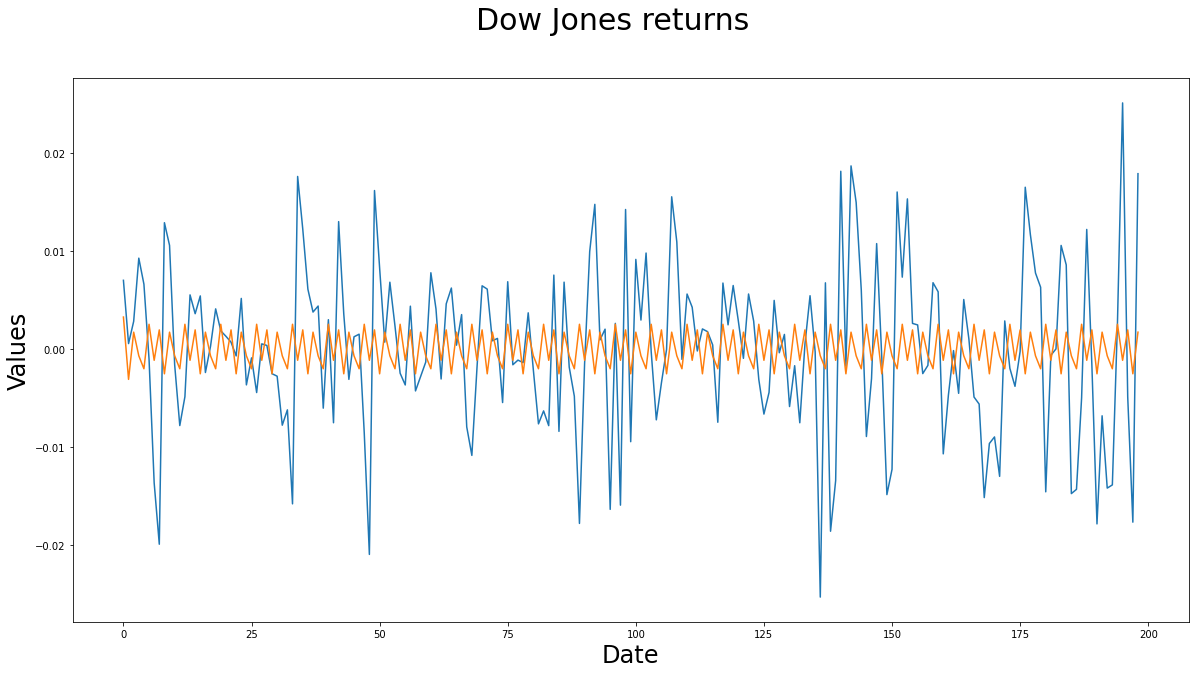

In [32]:
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=7)),
    ("arima", arima.AutoARIMA(stepwise=True, 
                              trace=1, 
                              error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])


pipe.fit(xtrain)
preds, conf_int = pipe.predict(n_periods=xvalid.shape[0], return_conf_int=True)
# print("\nForecasts:")
# print(preds)

fig, ax = plt.subplots()
fig.suptitle("Dow Jones returns", fontsize=30)
ax.plot(
    xvalid
  )
ax.plot(
    preds.reset_index(drop=True)
  )

ax.set_ylabel('Values', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

In [33]:
print(f"RMSE: {my_rmse(preds.reset_index(drop=True), xvalid)}")

RMSE: 0.0087


In [34]:
print(f"RMSE: {my_rmse([preds.reset_index(drop=True)[0]],[xvalid[0]])}")

RMSE: 0.0037


In [35]:
dow_jones_valid2 = dow_jones_ohlc_df[-int(1000*0.2):].copy().reset_index(drop=True)
dow_jones_valid2['Moving window ARIMA'] = pd.Series([x for x in preds])
dow_jones_valid2['Close returns'] = pd.Series(xvalid)
dow_jones_valid2['Close corrected by ARIMA'] = dow_jones_valid2.Close.shift(1) + dow_jones_valid2['Moving window ARIMA'] * dow_jones_valid2.Close.shift(1)

In [36]:
dow_jones_valid2

,Date,Open,High,Low,Close,Adj Close,Volume,Moving window ARIMA,Close returns,Close corrected by ARIMA
0,2021-04-30,33874.898438,33874.898438,33874.898438,33874.898438,33874.898438,0,0.003288,0.007035,NaN
1,2021-05-03,34113.199219,34113.199219,34113.199219,34113.199219,34113.199219,0,-0.003070,0.000580,33770.909593
2,2021-05-04,34133.000000,34133.000000,34133.000000,34133.000000,34133.000000,0,0.001747,0.002851,34172.796720
3,2021-05-05,34230.300781,34230.300781,34230.300781,34230.300781,34230.300781,0,-0.000666,0.009296,34110.278845
4,2021-05-06,34548.500000,34548.500000,34548.500000,34548.500000,34548.500000,0,-0.001986,0.006637,34162.309533
...,...,...,...,...,...,...,...,...,...,...
195,2022-02-24,33223.800781,33223.800781,33223.800781,33223.800781,33223.800781,0,-0.001123,0.025133,33094.582631
196,2022-02-25,34058.800781,34058.800781,34058.800781,34058.800781,34058.800781,0,0.001978,-0.004880,33289.517498
197,2022-02-28,33892.601562,33892.601562,33892.601562,33892.601562,33892.601562,0,-0.002501,-0.017635,33973.610942
198,2022-03-01,33294.898438,33294.898438,33294.898438,33294.898438,33294.898438,0,0.001747,0.017913,33951.812322


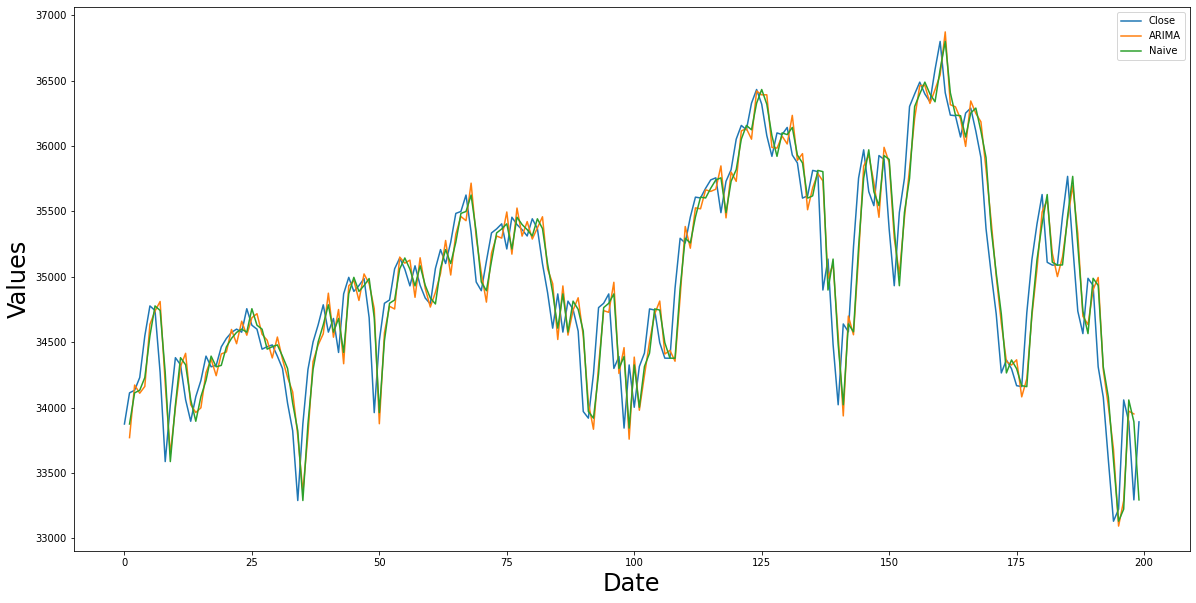

In [67]:
fig, ax = plt.subplots()
fig.suptitle("", fontsize=30)

ax.plot(
  dow_jones_valid2['Close'][:200],
  label="Close"
)
ax.plot(
  dow_jones_valid2['Close corrected by ARIMA'][:200],
  label="ARIMA"
)
ax.plot(
  dow_jones_valid2['Naive_model Close'][1:],
  label="Naive"
)


ax.legend(loc="best")
ax.set_ylabel('Values', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

In [44]:
dow_jones_valid2['Naive_model Close'] = dow_jones_valid2.Close.shift(1)

In [56]:
print(f"RMSE: {my_rmse(dow_jones_valid2[1:].Close, dow_jones_valid2['Naive_model Close'][1:])}")

RMSE: 297.7902


In [38]:
print(f"RMSE: {my_rmse(dow_jones_valid2['Close corrected by ARIMA'][1:199], dow_jones_valid2['Close'][1:199])}")

RMSE: 307.1816


In [40]:
dow_jones_returns_moving_window = dow_jones_ohlc_df.Close[-1000:].pct_change().dropna()
xtrain, xvalid = model_selection.train_test_split(dow_jones_returns_moving_window.values, test_size = int(len(dow_jones_returns)*0.2))

pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=7)),
    ("arima", arima.AutoARIMA(stepwise=True, 
                              trace=1, 
                              error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

preds = []
errors = []
prediced_converted_to_price_array = []
last_price = dow_jones_ohlc_df[-1000:].reset_index(drop=True)[-201:].Close.reset_index(drop=True)[0]

for i in range(len(xvalid)):
  print(f"----- Iteration {i} -----")
  pipe.fit(xtrain)
  single_pred, conf_int = pipe.predict(n_periods=1, return_conf_int=True)
  preds.append(single_pred)
  single_valid_obs = xvalid[i]
  xtrain = np.append(xtrain, single_valid_obs)
  converted_to_price = last_price + last_price * single_pred
  last_price = last_price + last_price * single_pred
  prediced_converted_to_price_array.append(converted_to_price)
  # xtrain.append()
  xtrain = xtrain[1:]


----- Iteration 0 -----
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4439.204, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4392.207, Time=1.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4425.165, Time=1.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4416.483, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4440.584, Time=0.71 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-4443.309, Time=0.41 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-4442.263, Time=2.96 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4431.395, Time=1.74 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4440.163, Time=2.66 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4443.108, Time=1.16 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 14.030 seconds
----- Iteration 1 -----
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4439.198, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4392.134

KeyboardInterrupt: 

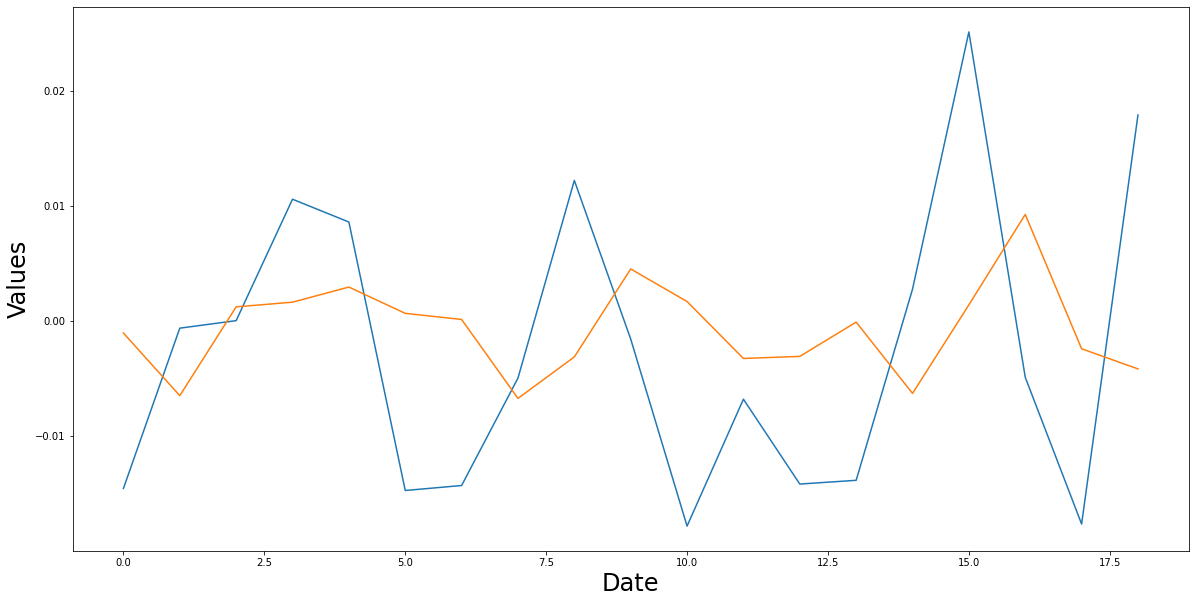

In [ ]:
fig, ax = plt.subplots()
# fig.suptitle("", fontsize=30)
ax.plot(
    xvalid
  
)
ax.plot(
  preds
)

ax.set_ylabel('Values', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

In [410]:
print(f"RMSE of Close: {my_rmse(preds, xvalid)}")

RMSE of Close: 0.0132


In [ ]:
print(f"RMSE of Close: {my_rmse(prediced_converted_to_price_array, dow_jones_ohlc_df.Close[-19:].reset_index(drop=True))}")

In [316]:
dow_jones_valid = dow_jones_ohlc_df[-int(100*0.2):].copy().reset_index(drop=True)
dow_jones_valid['Moving window ARIMA'] = pd.Series([x.item() for x in preds])

In [317]:
dow_jones_valid['Close returns'] = pd.Series(xvalid)

In [318]:
dow_jones_valid['Close corrected by ARIMA'] = dow_jones_valid['Close'].shift(1) + dow_jones_valid['Moving window ARIMA'] * dow_jones_valid['Close'].shift(1)

In [267]:
dow_jones_valid

,Date,Open,High,Low,Close,Adj Close,Volume,Moving window ARIMA,Close returns,Close corrected by ARIMA
0,2022-02-02,35629.300781,35629.300781,35629.300781,35629.300781,35629.300781,0,0.003288,0.007035,NaN
1,2022-02-03,35111.199219,35111.199219,35111.199219,35111.199219,35111.199219,0,-0.003735,0.000580,35496.214905
2,2022-02-04,35089.699219,35089.699219,35089.699219,35089.699219,35089.699219,0,0.001670,0.002851,35169.839625
3,2022-02-07,35091.101562,35091.101562,35091.101562,35091.101562,35091.101562,0,-0.000089,0.009296,35086.578254
4,2022-02-08,35462.800781,35462.800781,35462.800781,35462.800781,35462.800781,0,-0.003416,0.006637,34971.232134
5,2022-02-09,35768.101562,35768.101562,35768.101562,35768.101562,35768.101562,0,0.002666,-0.001006,35557.337449
6,2022-02-10,35241.601562,35241.601562,35241.601562,35241.601562,35241.601562,0,0.001319,-0.013632,35815.290634
7,2022-02-11,34738.101562,34738.101562,34738.101562,34738.101562,34738.101562,0,0.003851,-0.019887,35377.308522
8,2022-02-14,34566.199219,34566.199219,34566.199219,34566.199219,34566.199219,0,-0.001377,0.012912,34690.255480
9,2022-02-15,34988.800781,34988.800781,34988.800781,34988.800781,34988.800781,0,-0.005339,0.010602,34381.647918


In [319]:
print(f"RMSE of Close: {my_rmse(dow_jones_valid['Close corrected by ARIMA'][1:19], dow_jones_valid['Close'][1:19])}")

RMSE of Close: 311.6061


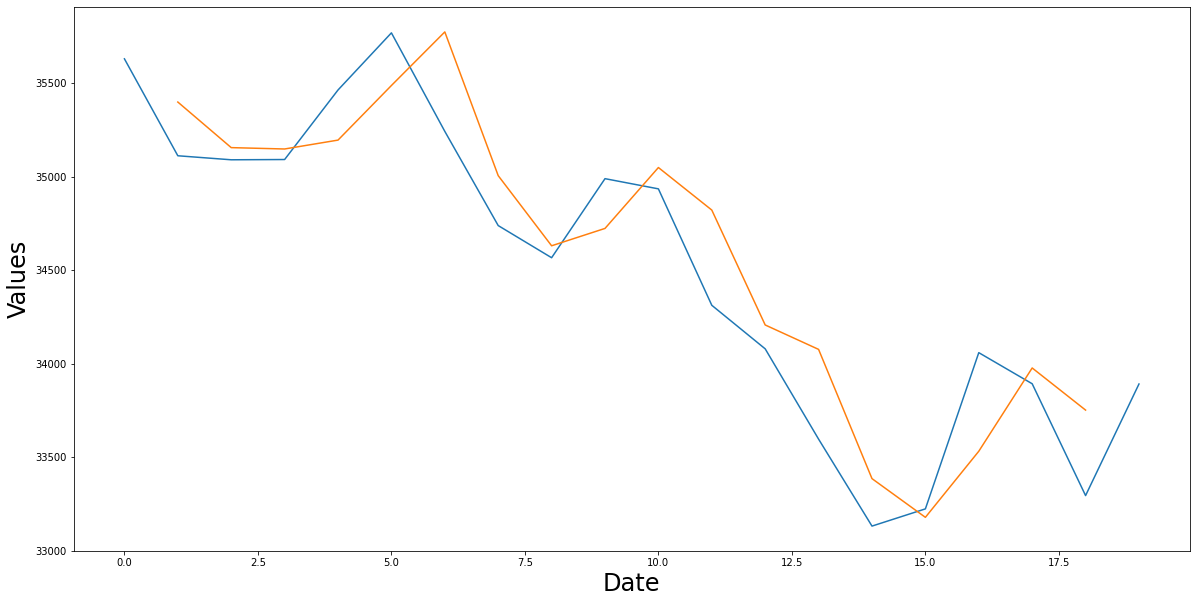

In [216]:
fig, ax = plt.subplots()
# fig.suptitle("", fontsize=30)
ax.plot(
  dow_jones_valid['Close']
)
ax.plot(
  dow_jones_valid['Close corrected by ARIMA']
)

ax.set_ylabel('Values', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

In [139]:

value = 10
some_return = 0.1
value_next_day_y = value + value * some_return

predicted_return = 0.05
value_next_day_y_hat = value + value * predicted_return
print(value_next_day_y)
print(value_next_day_y_hat)


11.0
10.5


In [ ]:
pd.DataFrame()

In [65]:
type(single_pred.item())

float

In [71]:
mean_squared_error(single_pred, [single_valid_obs])

0.00023066909103926654

C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


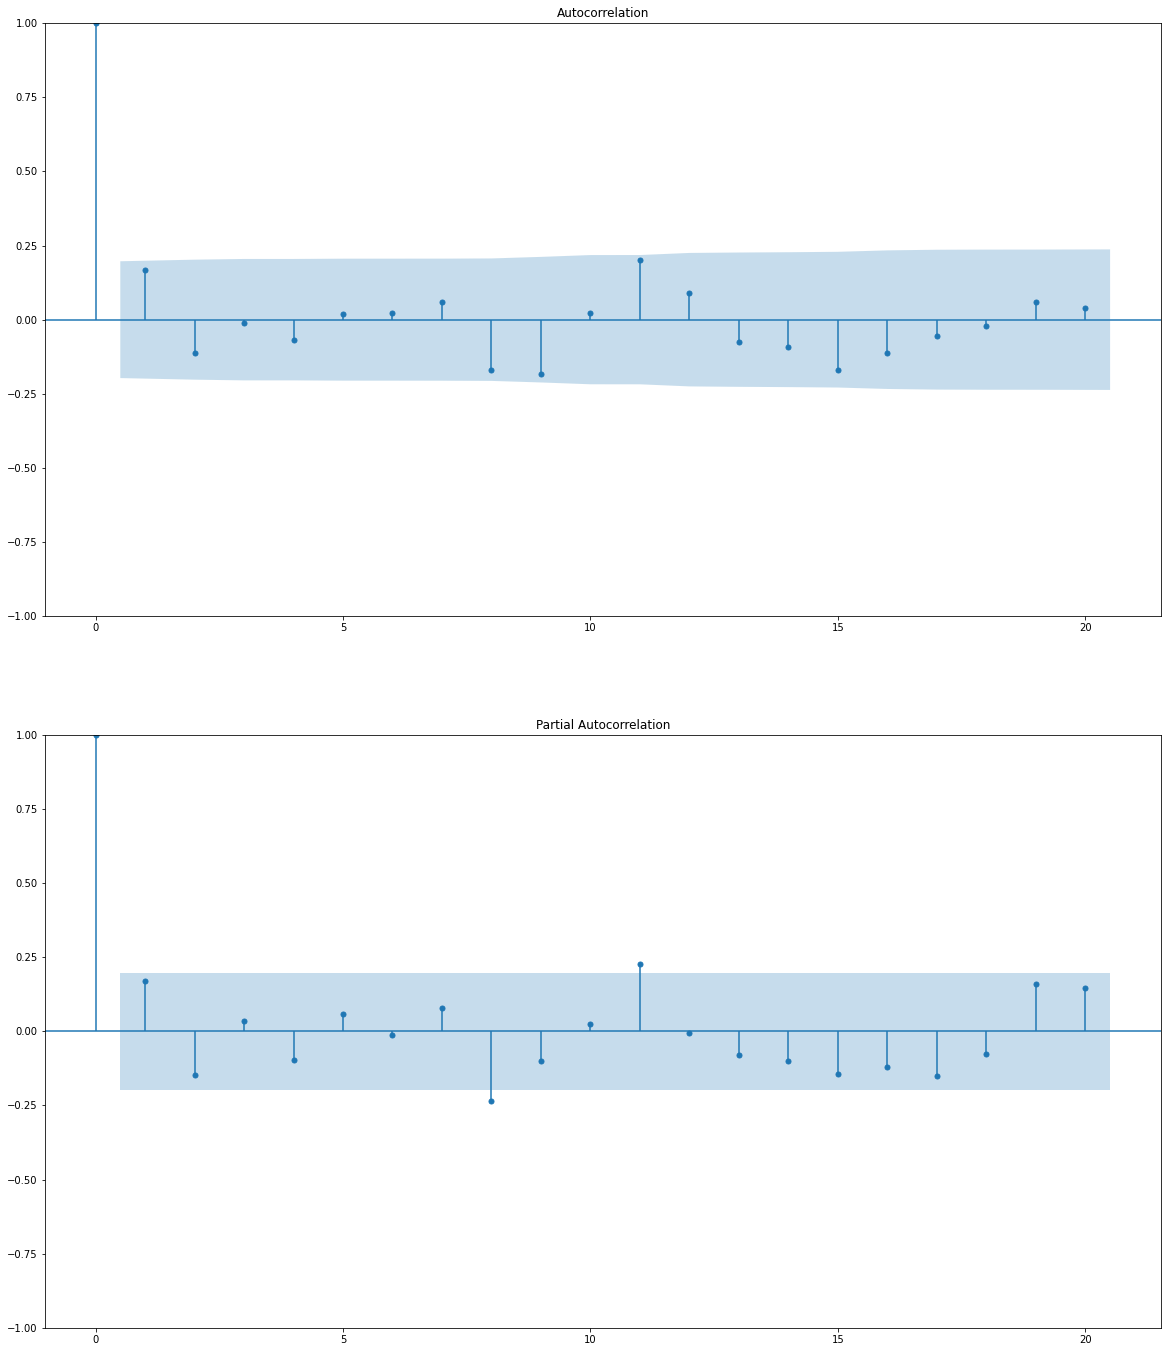

In [171]:
fig = plt.figure(figsize=(20,24))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dow_jones_returns, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dow_jones_returns, lags=20, ax=ax2)

In [88]:
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, 
                              trace=1, 
                              error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-524.634, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-526.835, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-529.241, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-529.054, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-527.250, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-527.225, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-525.243, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-527.563, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.818 seconds


Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [89]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 270.621
Date:                Wed, 14 Jun 2023   AIC                           -529.241
Time:                        23:56:54   BIC                           -514.949
Sample:                             0   HQIC                          -523.511
                                 - 80                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FOURIER_S4-0    -0.0001      0.001     -0.111      0.912      -0.003       0.002
FOURIER_C4-0     0.0015      0.001      1.052      0.293      -0.001       0.004
FOURIER_S4-1   -74.9047    1.1e-06  -6.83e+07      0.000     -74.905     -74.905
FOURIER_C4-1     0.0008      0.001      1.038      0.299      -0.001       0.002
ar.L1            0.2312      0.105      2.212      0.027       0.026       0.436
sigma2        6.737e-05   9.56e-06      7.047      0.000    4.86e-05    8.61e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.83   Skew:                             0.01
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.61e+20. Standard errors may be unstable.
"""

In [90]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds)


Forecasts:
80    0.000646
81   -0.001023
82   -0.000059
83    0.001783
84   -0.000373
85   -0.001291
86   -0.000089
87    0.001743
88   -0.000349
89   -0.001318
90   -0.000063
91    0.001717
92   -0.000323
93   -0.001344
94   -0.000036
95    0.001691
96   -0.000297
97   -0.001371
98   -0.000010
dtype: float64


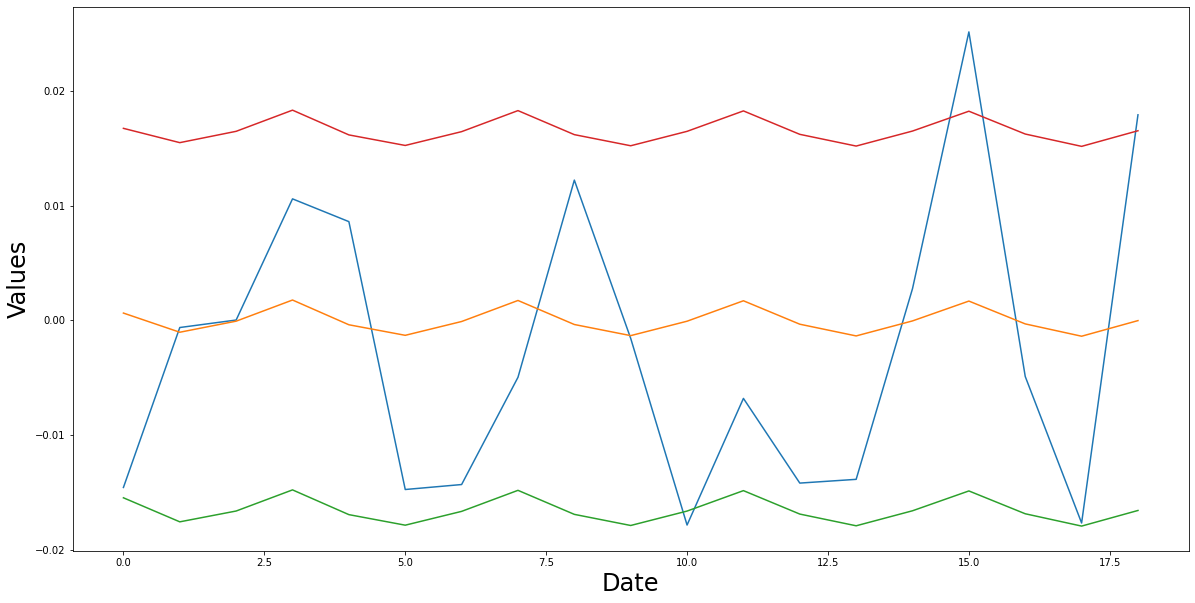

In [93]:
fig, ax = plt.subplots()
# fig.suptitle("", fontsize=30)
ax.plot(
    xvalid
  )
ax.plot(
    preds.reset_index(drop=True)
  )
ax.plot(
    conf_int
  )
# ax.plot(
#     conf_int
# )

ax.set_ylabel('Values', fontsize=24)
ax.set_xlabel('Date', fontsize=24)
ax.xaxis.set_major_locator(plt.AutoLocator())

plt.show()

C:\ML\kaggle\kaggle_competition\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $113.79\nSD: $6.68')

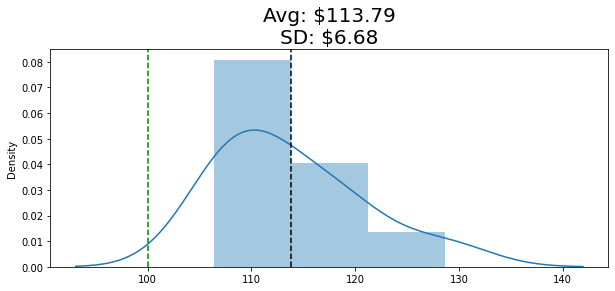

In [75]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

In [ ]:
nasdaq_returns_baseline = nasdaq_returns[-400:]
nasdaq_price_baseline = nasdaq_ohlc_df.Close[-400:]

run_simulation('Nasdaq', nasdaq_returns_baseline, nasdaq_price_baseline, 100, 0.5, None, verbose=False)

In [ ]:
tickerSymbol = 'Nasdaq'

nasdaq_returns_baseline = nasdaq_returns[-100:]
nasdaq_price_baseline = nasdaq_ohlc_df.Close[-100:]
final_amts = [run_simulation(nasdaq_returns_baseline, nasdaq_price_baseline, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=12)

In [ ]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

In [ ]:
type(returns)

In [ ]:
type(nasdaq_returns_baseline)

In [ ]:
tickerSymbol = 'Nasdaq'

nasdaq_returns_baseline = nasdaq_returns[-100:]
nasdaq_price_baseline = nasdaq_ohlc_df.Close[-100:]
run_simulation(nasdaq_returns_baseline, nasdaq_price_baseline, 100, 'last', None, verbose=False)

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(nasdaq_ohlc_df.Close)
plt.title('Nasdaq close price')
plt.grid(True)
plt.show()

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [218]:
def test_stationarity(timeseries, window_size=250):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

In [ ]:
# moving_average(nasdaq_ohlc_df.Close, 24)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-500:], 4)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-100:], 4, plot_intervals=True)

In [ ]:
# plotMovingAverage(nasdaq_ohlc_df[['Close']][-30:], 7, plot_intervals=True, plot_anomalies=True)

In [ ]:
nasdaq_decomposition = seasonal_decompose(nasdaq_ohlc_df.Close, period=250)
spy_decomposition = seasonal_decompose(spy_ohlc_df.Close, period=250)
dow_jones_decomposition = seasonal_decompose(dow_jones_ohlc_df.Close, period=250)

In [ ]:
nasdaq_decomposition2 = seasonal_decompose(nasdaq_ohlc_df.Close, model = 'additive', period=500)
nasdaq_decomposition2.plot()
plt.show()

In [ ]:
fig = plt.figure()  
fig = nasdaq_decomposition.plot()
fig.set_size_inches(15, 8)

In [ ]:
test_stationarity(nasdaq_ohlc_df.Close)

In [ ]:
fig = plt.figure(figsize=(20,24))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(nasdaq_ohlc_df.Close, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(nasdaq_ohlc_df.Close, lags=40, ax=ax2)

In [ ]:
# fig = plt.figure()  
# fig = spy_decomposition.plot()
# fig.set_size_inches(15, 8)

In [ ]:
# test_stationarity(spy_ohlc_df.Close)

In [ ]:
# fig = plt.figure()  
# fig = dow_jones_decomposition.plot()
# fig.set_size_inches(15, 8)

In [ ]:
# test_stationarity(dow_jones_ohlc_df.Close)

<h5>So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data.</h5>

- Deflation by CPI
- Logarithmic
- First Difference
- Seasonal Difference
- Seasonal Adjustment

In [ ]:
nasdaq_ohlc_df['first_difference_Close'] = nasdaq_ohlc_df.Close - nasdaq_ohlc_df.Close.shift(1)
test_stationarity(nasdaq_ohlc_df.first_difference_Close.dropna(inplace=False))

In [ ]:
fig = plt.figure(figsize=(20,24))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(nasdaq_ohlc_df.first_difference_Close.iloc[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(nasdaq_ohlc_df.first_difference_Close.iloc[1:], lags=40, ax=ax2)

In [ ]:
plt.plot(nasdaq_ohlc_df.first_difference_Close, label = 'First difference Close')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
nasdaq_ohlc_df['seasonal_difference_Close'] = nasdaq_ohlc_df.Close - nasdaq_ohlc_df.Close.shift(250)
test_stationarity(nasdaq_ohlc_df.seasonal_difference_Close.dropna(inplace=False))

In [ ]:
nasdaq_ohlc_df['seasonal_first_difference_Close'] = nasdaq_ohlc_df.first_difference_Close - nasdaq_ohlc_df.first_difference_Close.shift(250)
test_stationarity(nasdaq_ohlc_df.seasonal_first_difference_Close.dropna(inplace=False))

In [ ]:
lag_features = ["High", "Low", "Close"]
window_size = 250

df = nasdaq_ohlc_df[-1000:].copy()

df_rolled = df[lag_features].rolling(window = window_size, min_periods=0)
df_mean = df_rolled.mean().shift(1).reset_index()
df_std = df_rolled.std().shift(1).reset_index()

for feature in lag_features:
    df[feature + '_mean_lag' + str(window_size)] = df_mean[feature].values
    df[feature + '_std_lag' + str(window_size)] = df_std[feature].values

# Prophet can handle missing values, but ARIMA cannot
df.fillna(df.mean(), inplace=True)

In [ ]:
train_size = int(len(df) * 0.9)

In [ ]:
nasdaq_ohlc_df.columns

In [36]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.loc[Y_df.unique_id == 'H1']

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
743,H1,744,785.0
744,H1,745,756.0
745,H1,746,719.0
746,H1,747,703.0


<AxesSubplot:>

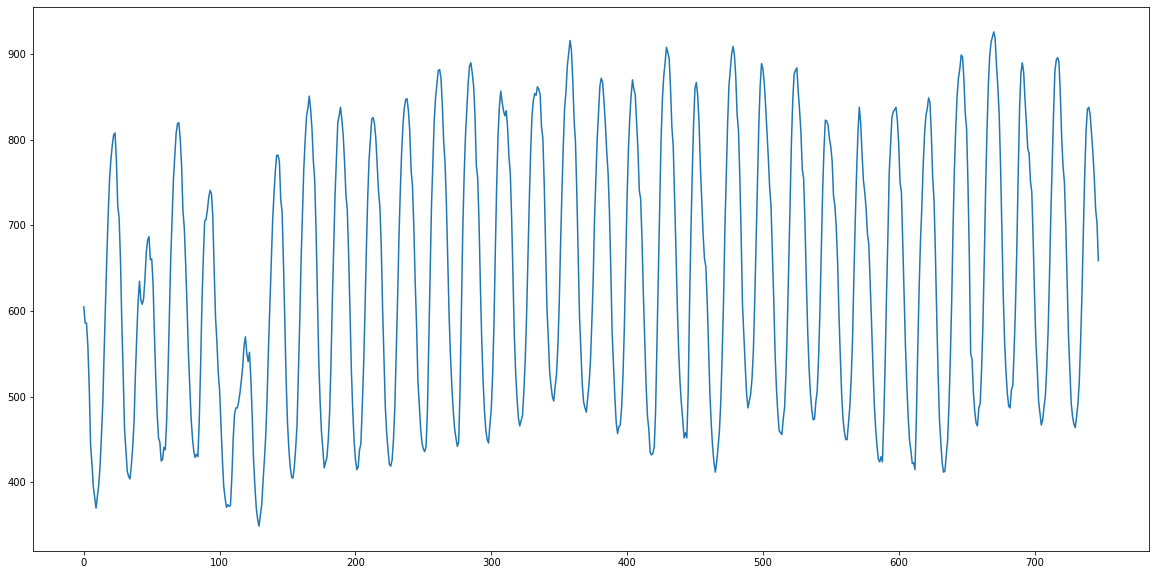

In [38]:
Y_df.loc[Y_df.unique_id == 'H1'].y.plot()

In [ ]:
from statsforecast import StatsForecast

sf = StatsForecast()

sf.plot(Y_df)

In [ ]:
df_fb = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df_fb.head()

In [ ]:
from prophet import Prophet



m = Prophet(daily_seasonality=False)
m.fit(df_fb)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

In [ ]:
np.array(forecast)[:, 1:]

In [ ]:
np.array(forecast)[:, :]

In [ ]:
fig2 = m.plot_components(np.array(forecast)[:, 1:])

In [ ]:
from statsforecast.adapters.prophet import AutoARIMAProphet

m = AutoARIMAProphet(daily_seasonality=False)

m.fit(df_fb)
# m.fit(df, disable_seasonal_features=False) # Uncomment for better AutoARIMA predictions
future = m.make_future_dataframe(365)
forecast = m.predict(future)


In [ ]:
fig = m.plot(forecast)

In [ ]:
# prepare the training / validation split
# df_train = df[df.Date < "2023"]
# df_valid = df[df.Date >= "2023"]
df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:]

exogenous_features = ['High_mean_lag'+str(window_size), 
                      'High_std_lag'+str(window_size), 
                      'Low_mean_lag'+str(window_size),
                      'Low_std_lag'+str(window_size), 
                      'Close_mean_lag'+str(window_size), 
                      'Close_std_lag'+str(window_size)]

In [ ]:
df_valid

In [ ]:
model_arima = auto_arima(df_train.Close, 
                          exogenous=df_train[exogenous_features], 
                          m = 1,  
                          # max ranges for the p,q,P,Q parameters - can be extended
                          # max_p= 3, max_q=3,    
                          # max_P=3, max_Q=3,
                          trace=True, 
                          error_action="ignore", suppress_warnings=True)
model_arima.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast = model_arima.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

In [ ]:
print(model_arima.summary())
model_arima.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# # Forecast
# fc, se, conf = model_arima.forecast(321, alpha=0.05)  # 95% conf
# # Make as pandas series
# fc_series = pd.Series(fc, index=df_valid.index)
# lower_series = pd.Series(conf[:, 0], index=df_valid.index)
# upper_series = pd.Series(conf[:, 1], index=df_valid.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(df_train, label='training data')
# plt.plot(df_valid, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
# plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('ARCH CAPITAL GROUP Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()


In [ ]:
df_valid

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(df_valid.Close)
plt.plot(df_valid.Forecast_ARIMAX)
plt.show()

In [ ]:


rmse = np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX))
print('RMSE:', rmse)

# RNN

In [ ]:
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse


In [25]:
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid

In [ ]:
def make_df_from(df):
  df_out = df[['Date', 'Close']].copy()
  df_out['Date'] = pd.to_datetime(df_out['Date'])
  df_out.set_index('Date', inplace=True)
  return df_out

In [ ]:
df_rnn_spy = make_df_from(spy_ohlc_df)
df_rnn_dow = make_df_from(dow_jones_ohlc_df)

In [ ]:
df_rnn = nasdaq_ohlc_df[['Date', 'Close']].copy()
df_rnn['Date'] = pd.to_datetime(df_rnn['Date'])
df_rnn.set_index('Date', inplace=True)
df_rnn.head()

In [ ]:
# df_rnn.Close.plot(xlabel = '')

In [ ]:
scaler = MinMaxScaler()
df_rnn = scaler.fit_transform(df_rnn)

In [ ]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

In [ ]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

In [ ]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10, input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()

In [ ]:
model1.summary()

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

In [ ]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

In [ ]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

In [ ]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

In [ ]:
y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

In [ ]:
# predict and calculate RMSE
y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
yvalid2 =  scaler.inverse_transform(yvalid)

In [ ]:
plt.plot(yvalid2, label = 'real')
plt.plot(y_pred2, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
print('RMSE model1: ' + str(my_rmse(y_pred1, scaler.inverse_transform(yvalid))))
print('RMSE model2: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [ ]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

In [ ]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

In [ ]:
y_pred3.shape

In [ ]:
# predict and calculate RMSE
y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)
yvalid3 =  scaler.inverse_transform(yvalid)

In [ ]:
y_pred3.shape, scaler.inverse_transform(yvalid).shape

In [ ]:
print('RMSE: ' + str(my_rmse(y_pred3, yvalid3)))

In [ ]:
# plt.plot(yvalid3, label = 'real')
# plt.plot(y_pred3, label = 'predicted')
# plt.ylabel('')
# plt.legend()
# plt.show()

In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [ ]:
def create_model4(out_dim):
    
    model=Sequential()
    model.add(GRU(10,input_shape= [None,1], return_sequences = True))
    model.add(GRU(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model4 = create_model4(out_dim = look_ahead)
model4.summary()

In [ ]:
model4.fit(xtrain, 
           ytrain, 
           validation_data=(xvalid, yvalid), 
           epochs = CFG.nepochs, 
           batch_size = CFG.bsize, 
           callbacks=[ early_stop])

y_pred4 = model4.predict(xvalid)
y_pred4 = scaler.inverse_transform(y_pred4)
yvalid4 = scaler.inverse_transform(yvalid)

In [ ]:
y_pred4.shape, yvalid4.shape

In [ ]:
print('RMSE: ' + str(my_rmse(y_pred4, yvalid4)))

In [ ]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [ ]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

In [ ]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

In [ ]:
yvalid5 = scaler.inverse_transform(yvalid)

In [ ]:
print('RMSE RNN model1: ' + str(my_rmse(y_pred1, yvalid1)))
print('RMSE RNN model2: ' + str(my_rmse(y_pred2, yvalid2)))
print('RMSE RNN model3: ' + str(my_rmse(y_pred3, yvalid3)))
print('RMSE GRU: ' + str(my_rmse(y_pred4, yvalid4)))
print('RMSE LSTM: ' + str(my_rmse(y_pred5, yvalid5)))

In [ ]:
# xtrain_small, xvalid_small = model_selection.train_test_split(nasdaq_ohlc_df[-1000:]['Close'].values, test_size = 300)

# pipe_small = pipeline.Pipeline([
#     ("fourier", ppc.FourierFeaturizer(m=250)),
#     ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
#                               seasonal=False,  # because we use Fourier
#                               suppress_warnings=True))
# ])

# pipe_small.fit(xtrain)

In [ ]:
eur_data = pd.read_csv("./data/fx_data.csv")

In [ ]:
eur_data.shape

In [ ]:
eur_data

In [ ]:
msft = Ticker("msft")

In [ ]:
msft.summary_detail

In [ ]:
s = Screener()
s.available_screeners

In [ ]:
s.get_screeners(['most_actives', 'day_gainers'], 5)

In [ ]:
# Compare downloads for all companies within the S&P500
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
sp500 = tables[0]['Symbol'].tolist()
sp500 = [symbol.replace(".", "-") for symbol in sp500]

In [ ]:
%%time
tickers = Ticker(sp500, asynchronous=True)
yq_data = tickers.history(period='ytd', interval='1d')

type(yq_data)
yq_data.shape
yq_data.head()

In [ ]:
yq_data.loc[('MMM')].index[:24]

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

In [ ]:
yq_data_MMM = yq_data.loc[('MMM')]

fig_MMM = go.Figure(data=[go.Candlestick(x=yq_data_MMM.index,
                open=yq_data_MMM['open'],
                high=yq_data_MMM['high'],
                low=yq_data_MMM['low'],
                close=yq_data_MMM['close'])])

fig_MMM.show()

In [ ]:
x = (3.613)**10
x = x/100
x